# Projekt Marketinganalyse

Modulprojekt für die Vorlesung __Applied Statistics__  
Wintersemester 2018
Hochschule der Medien, Stuttgart 

_Dozent:_ Prof. Dr. Jan Kirenz  
_Studenten:_ Stephanie Flohr, Benedikt Haußner, Robert Masendorf

**Hinweis:** Zu korrekten Darstellung der Ergebnisse in den MarkDowns muss die Nbextension ```Python Markdown``` aktiviert sein. Zusätzlich muss ein ```Trusted```Kernel verwendet werden.

In [1]:
#import sys
#if not sys.warnoptions:
#import warnings
#warnings.simplefilter("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as stopbuggingme
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_squared_error, r2_score
from statsmodels.discrete.discrete_model import MNLogit
sns.set() 
%matplotlib inline 
plt.style.use('ggplot')
pd.set_option('display.max_columns',24)

## Ziel der Arbeit

Wir betrachten einen Datensatz, der __Kundendaten einer Autoversicherung__ enthält.  
Mittels statistischer Modelle sollen __folgende Ansätze__ verfolgt werden:
+ __Regression:__ Wir werden versuchen, den ```Customer Lifetime Value``` zu prognostizieren, also die Menge Geld, die der Kunde für das Unternehmen wert ist.
+ __Klassifikation:__ Der Datensatz enthält Angaben darüber, ob die Kunden auf einen Kundenansprache reagiert haben. Wir werden versuchen, die Kunden danach zu klassifizieren - können wir etwas darüber lernen, welche Attribute dafür sprechen, dass ein Kunde auf Werbung reagiert?

Für diesen Zweck sollen diverse statistische Modelle, aber auch uni- und bivariate Analysen sowie Visulaisierungen genutzt werden.

## Import der Daten und Betrachtung der Attribute

IBM hat im März 2015 den genutzten Datenbestand als Übungsbeispiel unter dem Namen `SAMPLE DATA: Marketing Customer Value Analysis`veröffentlicht. Das csv kann [hier](https://www.ibm.com/communities/analytics/watson-analytics-blog/marketing-customer-value-analysis/) herunterleladen werden.

### Import der Daten

In [3]:
df = pd.read_csv('marketing_customer_marketing_raw_data.csv')

Der DataFrame hat __folgende Dimensionen__:
+ Anzahl der Attribute: {{df.shape[1]}}
+ Anzahl der Datensätze: {{df.shape[0]}}

In [4]:
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


### Beschreibung der Attribute
+ ```Customer_ID```: Eindeutig Kombination aus Buchstaben und Zahlen, zur Identifizierung des Kundens.  
+ ```State```: Bundesstaat in den Vereinigten Staaten, in welchem der Kunde wohnt.  
+ ```Customer_Lifetime_Value```: Durchschnittlicher Wert des Kundens für das Unternehmen während seines gesamten Lebenszyklus. Der Wert ist diskontiert auf den Betrachtungszeitpunkt.  
+ ```Response```: Binärer Wert, ob der Kunde auf die Marketingmaßnahme reagiert hat.  
+ ```Coverage```: Der aktuelle Tarif, in welchem sich der angesprochene Kunde befindet.  
+ ```Education```: Der Bildungsstatus des angesprochenen Kunden.  
+ ```Effective_To_Date```: Laufzeitende der aktuellen Versicherung.  
+ ```Employment_Status```: Arbeitsverhältnis des Kundens.
+ ```Gender```: Geschlecht des Kundens.  
+ ```Income```: Jährliches Einkommen des Kundens in Dollar.  
+ ```Location_Code```: Wohnumgebung des Kundens in Bezug auf die Flächenverdichtung.  
+ ```Marital_Status```: Familienstand des Kundens.  
+ ```Monthly_Premium_Auto```: Monatliche Versicherungsrate.  
+ ```Months_Since_Last_Claim```: Vergangene Monate seit dem die Versicherung zuletzt in Anspruch genommen wurde.  
+ ```Months_Since_Policy_Inception```: Vergangene Monate seit Beginn der aktuellen Verischerungspolice.  
+ ```Number_of_Open_Complaints```: Anzahl der noch offenen Schadensfälle.  
+ ```Number_of_Policies```: Gesamtanzahl der Policen seit Versicherungsbeginn.  
+ ```Policy_Type```: Feststellung, ob es sich um eine private, eine geschäftliche oder eine Sonderpolice handelt. 
+ ```Policy```: Akuelle Tarifstufe, in der der Kunde sich befindet.  
+ ```Renew_Offer_Type```: Das dem Kunden unterbreitete neue Angebot.  
+ ```Sales_Channel```: Der Kanal, über welchen das Angebot übermittelt wurde.  
+ ```Total_Claim_Amount```: In Anspruch genommene Versicherungssumme.  
+ ```Vehicle_Class```: Art des versicherten Autos.  
+ ```Vehicle_Size```: Größenordnung des versicherten Autos.

## Datenbereinigung

### Umbenennen der Spalten

Hier sehen wir die Spaltennamen, wie sie aktuell im Column-Index stehen:

In [5]:
df.columns

Index(['Customer', 'State', 'Customer Lifetime Value', 'Response', 'Coverage',
       'Education', 'Effective To Date', 'EmploymentStatus', 'Gender',
       'Income', 'Location Code', 'Marital Status', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Policy Type',
       'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount',
       'Vehicle Class', 'Vehicle Size'],
      dtype='object')

Einige dieser Namen dürften im weiteren Verlauf für Probleme sorgen, da sie beispielsweise Leerzeichen enthalten. Daher benennen wir sie um:

In [6]:
df = df.rename(index=str, columns={"Customer":"Customer_ID",
                                   "Customer Lifetime Value":"Customer_Lifetime_Value",
                                   "Effective To Date":"Effective_To_Date", 
                                   "EmploymentStatus":"Employment_Status", 
                                   "Location Code":"Location_Code", 
                                   "Marital Status":"Marital_Status",
                                   "Monthly Premium Auto":"Monthly_Premium_Auto",
                                   "Months Since Last Claim":"Months_Since_Last_Claim",
                                   "Months Since Policy Inception":"Months_Since_Policy_Inception",
                                   "Number of Open Complaints":"Number_of_Open_Complaints",
                                   "Number of Policies":"Number_of_Policies",
                                   "Policy Type":"Policy_Type",
                                   "Renew Offer Type":"Renew_Offer_Type",
                                   "Sales Channel":"Sales_Channel",
                                   "Total Claim Amount":"Total_Claim_Amount",
                                   "Vehicle Class":"Vehicle_Class", 
                                   "Vehicle Size":"Vehicle_Size"})

### Prüfung auf Duplikate

Um sicherzustellen, dass die ```Customer-ID``` tatsächlich als Primärschlüssel dienen kann, prüfen wir die Datensätze auf Duplikate.

#### Einfacher Duplikatscheck

In [7]:
print('Anzahl Datensätze:\t\t{}'.format(len(df.Customer_ID)))
print('Anzahl eindeutiger Kunden-IDs:\t{}'.format(len(df.Customer_ID.value_counts())))

Anzahl Datensätze:		9134
Anzahl eindeutiger Kunden-IDs:	9134


Da beide Zahlen gleich sind, wissen wir, dass keine der Kunden-IDs doppelt angelegt wurde.

#### Komplexer Duplikatscheck

Allerdings kann es sein, dass ein Kunde doppelt mit zwei unterschiedlichen IDs angelegt wurde. Daher suchen wir nach Datensätzen, deren Werte für ein Subset der Attribute immer gleich ist - dies würde zumindest einen Anfangsverdacht rechtfertigen, der dann manuell überprüft werden müsste.  

Ein solches Subset könnte folgendermaßen aussehen:

In [8]:
duplicate_subset = ['State', 'Education', 'Employment_Status', 'Gender', 'Location_Code', 'Marital_Status']

Hier wurden alle Attribute berücksichtigt, die nichts mit der Versicherung an sich zu tun haben - denn letztere könnten sich ja je nach Aufnahme unterscheiden, beispielsweise, wenn eine neue Police abgeschlossen wurde, ohne dass der Vertreter gemerkt hat, dass der Kunde bereits in der Karte ist.  
Fraglich ist, wie viele Kombinationenen hier möglich sind:

In [9]:
combinations = 1
for attribute in duplicate_subset:
    combinations = combinations * df[attribute].nunique()
print("Mögliche Kombinationen:\t{}".format(combinations))

Mögliche Kombinationen:	2250


Bei {{df.shape[0]}} Datensätzen ergibt das so keinen Sinn, bei Gleichverteilung gibt es jede Kombination ca vier Mal. Trotzdem interessiert uns, wie viele Kunden "einzigartig" sind:

In [10]:
df.duplicated(subset=duplicate_subset, keep=False).value_counts()

True     8843
False     291
dtype: int64

Es gibt also 291 Kunden, die sicher keine Duplikate sind - eine manuelle Überprüfung bietet sich allerdings bei 8843 Kunden nicht an.

### Prüfung auf Missing Data

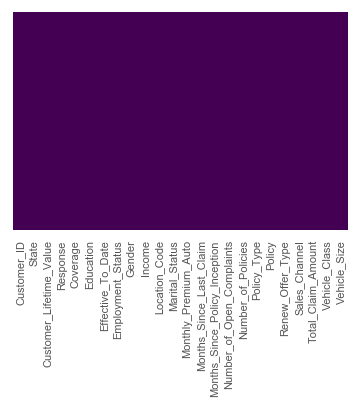

In [11]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [12]:
df.isnull().sum()

Customer_ID                      0
State                            0
Customer_Lifetime_Value          0
Response                         0
Coverage                         0
Education                        0
Effective_To_Date                0
Employment_Status                0
Gender                           0
Income                           0
Location_Code                    0
Marital_Status                   0
Monthly_Premium_Auto             0
Months_Since_Last_Claim          0
Months_Since_Policy_Inception    0
Number_of_Open_Complaints        0
Number_of_Policies               0
Policy_Type                      0
Policy                           0
Renew_Offer_Type                 0
Sales_Channel                    0
Total_Claim_Amount               0
Vehicle_Class                    0
Vehicle_Size                     0
dtype: int64

Wir sehen dass __keine Daten fehlen__, also keine Gegenmaßnahmen (Ausschluss der betroffenen Datensätze, Imputation, ect) getroffen werden müssen.

### Anpassung der Datentypen

Nachdem wir augenscheinlich auch kategoriale Daten vorliegen haben, diese aber beim Import nicht automatisiert erkannt werden, werden wir auch die Datentypen abändern.  
Dabei legen wir auch speziell Wert auf eine effiziente Datenhaltung, einen entsprechenden Blogpost findet man zb bei [Dataquest](https://www.dataquest.io/blog/pandas-big-data/).

#### Ist-Zustand vor der Transformation

Bevor wir Umwandlungen vornehmen, prüfen wir den Ist-Zustand.  
Hier finden sich die __aktuellen Datentypen__, auch der __belegte Speicherplatz__ wird gemessen:

In [13]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 9134 entries, 0 to 9133
Data columns (total 24 columns):
Customer_ID                      9134 non-null object
State                            9134 non-null object
Customer_Lifetime_Value          9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective_To_Date                9134 non-null object
Employment_Status                9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location_Code                    9134 non-null object
Marital_Status                   9134 non-null object
Monthly_Premium_Auto             9134 non-null int64
Months_Since_Last_Claim          9134 non-null int64
Months_Since_Policy_Inception    9134 non-null int64
Number_of_Open_Complaints        9134 non-null int64
Number_of_Policies               9134 

#### Umwandlung zu Datetime

In [14]:
df.Effective_To_Date = pd.to_datetime(df.Effective_To_Date)

#### Umwandlung in kategoriale Variablen

In [15]:
df.State = pd.Categorical(df.State)
df.Response = pd.Categorical(df.Response)
df.Coverage = pd.Categorical(df.Coverage)
df.Education = pd.Categorical(df.Education)
df.Employment_Status = pd.Categorical(df.Employment_Status)
df.Gender = pd.Categorical(df.Gender)
df.Location_Code = pd.Categorical(df.Location_Code)
df.Marital_Status = pd.Categorical(df.Marital_Status)
df.Policy_Type = pd.Categorical(df.Policy_Type)
df.Policy = pd.Categorical(df.Policy)
df.Renew_Offer_Type = pd.Categorical(df.Renew_Offer_Type)
df.Sales_Channel = pd.Categorical(df.Sales_Channel)
df.Vehicle_Class = pd.Categorical(df.Vehicle_Class)
df.Vehicle_Size = pd.Categorical(df.Vehicle_Size)

Zusätzlich werden die ordinalen Attribute als solche gekennzeichnet und die möglichen Werte in die richtige Reiehnfolge gebracht:

In [16]:
df.Coverage = df.Coverage.cat.reorder_categories(['Basic',
                                                  'Extended',
                                                  'Premium'],
                                                 ordered=True)
df.Coverage.dtype

CategoricalDtype(categories=['Basic', 'Extended', 'Premium'], ordered=True)

In [17]:
df.Education = df.Education.cat.reorder_categories(['High School or Below',
                                                    'College',
                                                    'Bachelor',
                                                    'Master',
                                                    'Doctor'],
                                                   ordered=True)
df.Education.dtype

CategoricalDtype(categories=['High School or Below', 'College', 'Bachelor', 'Master',
                  'Doctor'],
                 ordered=True)

In [18]:
df.Vehicle_Size = df.Vehicle_Size.cat.reorder_categories(['Small',
                                                          'Medsize',
                                                          'Large'],
                                                         ordered=True)
df.Vehicle_Size.dtype

CategoricalDtype(categories=['Small', 'Medsize', 'Large'], ordered=True)

#### Umwandlung der Integervariablen

Unsere Attribute haben __folgende Minimal- und Maximalwerte__:

In [19]:
df.describe(include=np.int_).loc[['min', 'max']]

,Income,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies
min,0.0,61.0,0.0,0.0,0.0,1.0
max,99981.0,298.0,35.0,99.0,5.0,9.0


Wir können also auf die __Abbildung von negativen Zahlen verzichten__.  
Folgende __unsigned Datentypen__ mit sich unterscheidenden Wertebereichen stehen für Integer-Werte zur Verfügung:

In [20]:
pd.DataFrame(index=['max'], data={"uint8":[np.iinfo("uint8").max],
                                  "uint16":[np.iinfo("uint16").max],
                                  "uint32":[np.iinfo("uint32").max],
                                  "uint64":[np.iinfo("uint64").max]})

,uint8,uint16,uint32,uint64
max,255,65535,4294967295,18446744073709551615


Praktischerweise gibt es das Argument ```downcast```, das bei einem ```apply``` automatisch den Datentyp mit dem niedrigsten Speicherplatzverbrauch nutzt - nur dass es eben ```unsigned``` sein soll, muss man der Funktion mitgeben:

In [21]:
int_columns = df.select_dtypes(include='int').columns
df[int_columns] = df[int_columns].apply(pd.to_numeric,downcast='unsigned')

In [22]:
df[int_columns].dtypes

Income                           uint32
Monthly_Premium_Auto             uint16
Months_Since_Last_Claim           uint8
Months_Since_Policy_Inception     uint8
Number_of_Open_Complaints         uint8
Number_of_Policies                uint8
dtype: object

Wir sehen: das hat gut geklappt!

### Umwandlung der Float Variablen

Ebenso gehen wir für die Float-Variablen vor:

In [23]:
df.describe(include="float").loc[['min', 'max']]

,Customer_Lifetime_Value,Total_Claim_Amount
min,1898.007675,0.099007
max,83325.381190,2893.239678


In [24]:
pd.DataFrame(index=['max'], data={"float16":[np.finfo("float16").max],
                                  "float32":[np.finfo("float32").max],
                                  "float64":[np.finfo("float64").max]})

,float16,float32,float64
max,65504.0,3.402823e+38,1.797693e+308


In [25]:
float_columns = df.select_dtypes(include='float').columns
df[float_columns] = df[float_columns].apply(pd.to_numeric, downcast='float')

In [26]:
df[float_columns].dtypes

Customer_Lifetime_Value    float32
Total_Claim_Amount         float32
dtype: object

Auch dieser Schritt war erfolgreich.

### Ist-Zustand nach der Transformation

Jetzt wollen wir noch prüfen, wie sich die Änderungen auf den DataFrame auswirken:

In [27]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 9134 entries, 0 to 9133
Data columns (total 24 columns):
Customer_ID                      9134 non-null object
State                            9134 non-null category
Customer_Lifetime_Value          9134 non-null float32
Response                         9134 non-null category
Coverage                         9134 non-null category
Education                        9134 non-null category
Effective_To_Date                9134 non-null datetime64[ns]
Employment_Status                9134 non-null category
Gender                           9134 non-null category
Income                           9134 non-null uint32
Location_Code                    9134 non-null category
Marital_Status                   9134 non-null category
Monthly_Premium_Auto             9134 non-null uint16
Months_Since_Last_Claim          9134 non-null uint8
Months_Since_Policy_Inception    9134 non-null uint8
Number_of_Open_Complaints        9134 non-null uint8
Number_of_Po

__Wir sehen:__
+ Die Datentypen wurden sinnvoll umgewandelt. Einzig ```Customer_ID``` wurde nicht angefasst, da hier aber ausschließlich unique Werte vorliegen, kostet der Wörterbuchansatz von ```Categorical``` mehr, als er bringt.
+ Der Speicherplatzbedarf ist fast um den ```Faktor 10``` gesunken - was im ```MB```-Bereich kaum einen Unterschied macht, sehr wohl aber, sobald man mit ```GB``` arbeitet.

## Univariate Analyse

Im Folgenden unterziehen wir alle Attribute einer univariaten Analyse.

### Hilfsfunktionen
Um uns später das Leben einfacher und den Code übersichtlicher zu machen, definieren wir uns Helper-Funktionen:

In [28]:
def univariat_analysis_number(dataframe, column):
    print(dataframe[column].name.upper()+"\n")
    print("Anzahl Datensätze:\t{}".format(dataframe[column].count()))
    print("Kleinster Betrag:\t{}".format(dataframe[column].min()))
    print("Median:\t\t\t{}".format(dataframe[column].median()))
    print("Durchschnitt:\t\t{0:.2f}".format(dataframe[column].mean()))
    print("Größter Betrag:\t\t{}".format(dataframe[column].max()))

    pd.DataFrame(dataframe[column]).boxplot(figsize=(12,1), vert=False, showfliers=True)
    plt.axvline(x=dataframe[column].mean(), color='blue')
    plt.show()
    
    if dataframe[column].max() >= 3 * dataframe[column].quantile(q=0.75):
        pd.DataFrame(dataframe[column]).boxplot(figsize=(12,1), vert=False, showfliers=False)
        plt.axvline(x=dataframe[column].mean(), color='blue')
        plt.show()
    print("*"*100+"\n")

In [29]:
def univariat_analysis_categorical(dataframe, column, kind='bar', figsize=(11,5)):
    print(dataframe[column].name.upper()+"\n")
    print("Anzahl Datensätze:\t\t\t{}".format(dataframe[column].count()))
    print("Häufigkeit des häufigsten Wertes:\t{}".format(dataframe.groupby(column)[column].count().max()))
    print("Häufigkeit des seltensten Wertes:\t{}".format(dataframe.groupby(column)[column].count().min()))
    ax = dataframe.groupby(column)[column].count().plot(kind=kind, rot=0, figsize=figsize)
    if kind == 'bar':
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.0, p.get_height() * 1.005))
    plt.ylabel("Anzahl")
    plt.show()
    print("*"*100+"\n")

### Numerische Variablen

Wir beginnen mit den numerischen Attributen:

In [30]:
df.select_dtypes(include=np.number).columns.tolist()

['Customer_Lifetime_Value',
 'Income',
 'Monthly_Premium_Auto',
 'Months_Since_Last_Claim',
 'Months_Since_Policy_Inception',
 'Number_of_Open_Complaints',
 'Number_of_Policies',
 'Total_Claim_Amount']

#### Customer Lifetime Value

CUSTOMER_LIFETIME_VALUE

Anzahl Datensätze:	9134
Kleinster Betrag:	1898.0076904296875
Median:			5780.18212890625
Durchschnitt:		8004.94
Größter Betrag:		83325.3828125


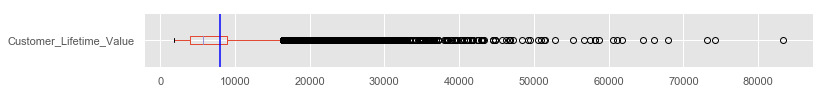

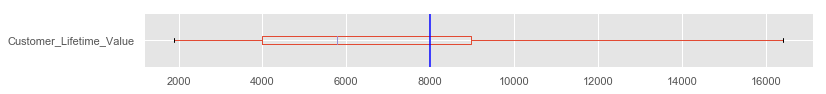

****************************************************************************************************



In [31]:
univariat_analysis_number(df, 'Customer_Lifetime_Value')

Nachdem hier gilt: ```Mean > Median``` folgern wir, dass wir ein paar __heftige Ausreißer__ in den Daten haben, die den Durchschnitt start verzerren.  
Eventuell sollten diese speziell behandel werden, dafür muss später das ```Residuals-vs-Leverage```-Diagramm genau betrachtet werden.

#### Income

INCOME

Anzahl Datensätze:	9134
Kleinster Betrag:	0
Median:			33889.5
Durchschnitt:		37657.38
Größter Betrag:		99981


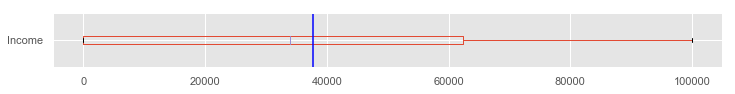

****************************************************************************************************



In [32]:
univariat_analysis_number(df, 'Income')

Das Einkommen scheint __einigermaßen normalverteilt__ zu sein, was uns entgegenkommt.  
Nachdem das erste Quantil fast bei ```0``` liegt, haben wir es trotzdem mit einer linkssteilen Verteilung zu tun.

#### Monthly_Premium_Auto

MONTHLY_PREMIUM_AUTO

Anzahl Datensätze:	9134
Kleinster Betrag:	61
Median:			83.0
Durchschnitt:		93.22
Größter Betrag:		298


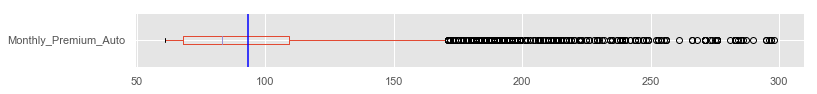

****************************************************************************************************



In [33]:
univariat_analysis_number(df, 'Monthly_Premium_Auto')

Auch bei den monatlichen Prämien gibt es __wieder Ausreißer__ nach oben.  
Versichert sind auch Menschen, die das __Dreifache des Durchschnitts__ zahlen.

#### Months_Since_Last_Claim

MONTHS_SINCE_LAST_CLAIM

Anzahl Datensätze:	9134
Kleinster Betrag:	0
Median:			14.0
Durchschnitt:		15.10
Größter Betrag:		35


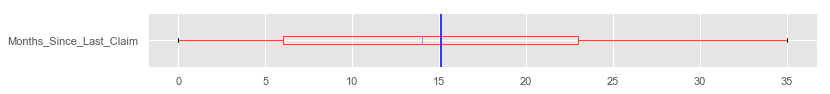

****************************************************************************************************



In [34]:
univariat_analysis_number(df, 'Months_Since_Last_Claim')

Hier sehen wir eine __wunderschöne Normalverteilung__.  
Wobei wir uns als Firma eventuell fragen sollten, warum Ansprüche im Durchschnitt 1,25 Jahre offen sind.

#### Months_Since_Policy_Inception

MONTHS_SINCE_POLICY_INCEPTION

Anzahl Datensätze:	9134
Kleinster Betrag:	0
Median:			48.0
Durchschnitt:		48.06
Größter Betrag:		99


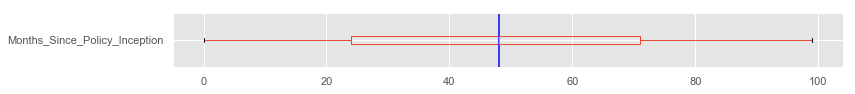

****************************************************************************************************



In [35]:
univariat_analysis_number(df, 'Months_Since_Policy_Inception')

Hier sehen wir eine __nahezu perfekte Normalverteilung__.

#### Number_of_Open_Complaints

NUMBER_OF_OPEN_COMPLAINTS

Anzahl Datensätze:	9134
Kleinster Betrag:	0
Median:			0.0
Durchschnitt:		0.38
Größter Betrag:		5


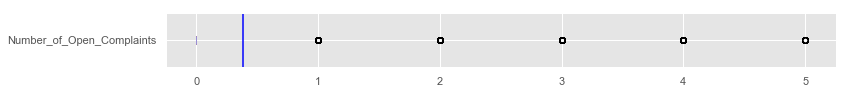

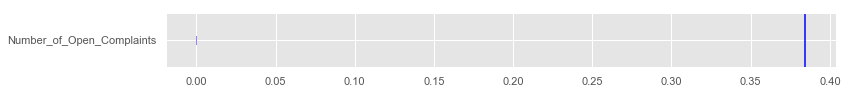

****************************************************************************************************



In [36]:
univariat_analysis_number(df, 'Number_of_Open_Complaints')

Wir sehen schon keine Box mehr - es gibt fast keine offenen Beschwerden:

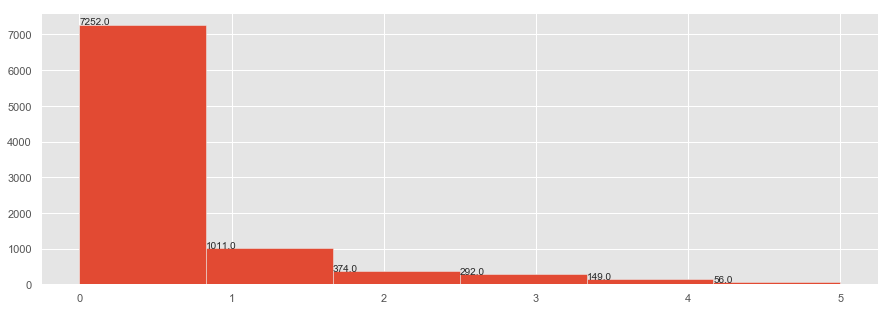

In [37]:
ax = df.Number_of_Open_Complaints.hist(figsize=(15,5), bins=df.Number_of_Open_Complaints.nunique())
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.005))
plt.show()

#### Number_of_Policies

NUMBER_OF_POLICIES

Anzahl Datensätze:	9134
Kleinster Betrag:	1
Median:			2.0
Durchschnitt:		2.97
Größter Betrag:		9


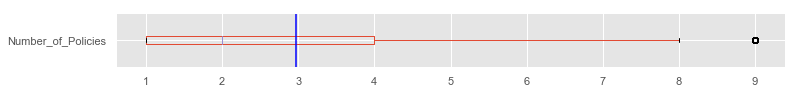

****************************************************************************************************



In [38]:
univariat_analysis_number(df, 'Number_of_Policies')

Auch hier gibt es __wieder ein paar Ausreißer nach oben__.  
Wir gehen wegen des Aufbaus des Datenbestandes davon aus, dass ein Versicherungsnehmen nur ein Auto gleichzeitig versichern kann, eine Menge Kunden versichern also auch andere Dinge bei uns.

#### Total_Claim_Amount

TOTAL_CLAIM_AMOUNT

Anzahl Datensätze:	9134
Kleinster Betrag:	0.0990070030093193
Median:			383.9454345703125
Durchschnitt:		434.09
Größter Betrag:		2893.23974609375


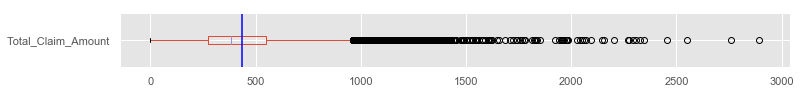

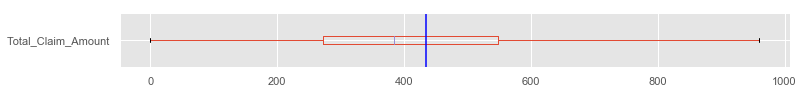

****************************************************************************************************



In [39]:
univariat_analysis_number(df, 'Total_Claim_Amount')

Interessant ist auch hier zu sehen: Median und Durchschnitt sind nicht allzuweit voneinander entfernt, allerdings haben ein paar wenige Kunden sehr hohe Forderungen gestellt, die in der Realität natürlich überprüft werden müssten.  
Die ausreißenden Datensätze sollten wir uns auch genauer anschauen, wenn wir das ```Residuals-vs-Leverage```-Diagramm interpretieren.

### Kategoriale Variablen

Nachdem wir es mit einer großen Zahl an kategorialen Attributen zu tun haben, besprechen wir nur die auffälligsten hier einzeln, für die restlichen werden nur die Plots erzeugt.  
Folgende kategoriale Variablen finden sich im Datenbestand:

In [40]:
categorical_columns = df.select_dtypes(include="category").columns.tolist()
categorical_columns

['State',
 'Response',
 'Coverage',
 'Education',
 'Employment_Status',
 'Gender',
 'Location_Code',
 'Marital_Status',
 'Policy_Type',
 'Policy',
 'Renew_Offer_Type',
 'Sales_Channel',
 'Vehicle_Class',
 'Vehicle_Size']

#### Response

RESPONSE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	7826
Häufigkeit des seltensten Wertes:	1308


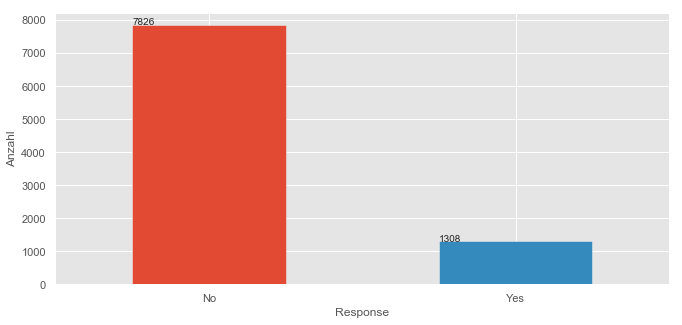

****************************************************************************************************

Anteil der Rückmeldungen:	0.14320122618786948


In [41]:
column = 'Response'
univariat_analysis_categorical(df, column)
print("Anteil der Rückmeldungen:\t{}".format(df[column].value_counts()['Yes']/df[column].count()))
if column in categorical_columns: categorical_columns.remove(column)

Wir sehen: wir haben 14% Rückmeldungen. Dies ist für eine Marketingmaßnahme generell nicht als schlecht anzusehen.  
Nachdem ```Response``` unsere Zielvariable für die Klassifikation ist, sehen wir hier allerdings Probleme auf uns zukommen, da ein hoher Bias vorliegt.

#### Employment_Status

EMPLOYMENT_STATUS

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	5698
Häufigkeit des seltensten Wertes:	282


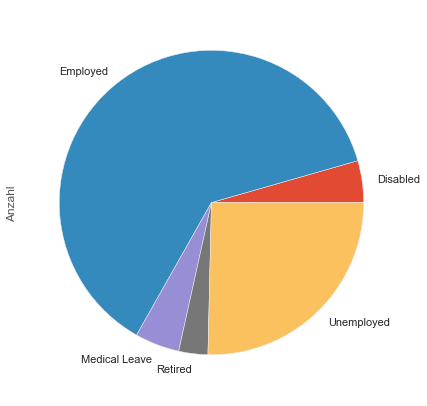

****************************************************************************************************

Anteil der Arbeitslosen:	0.25366761550251804


In [42]:
column = 'Employment_Status'
univariat_analysis_categorical(df, column, 'pie', (7,7))
print("Anteil der Arbeitslosen:\t{}".format(df[column].value_counts()['Unemployed']/df[column].count()))
if column in categorical_columns: categorical_columns.remove(column)

Interessant ist zu beobachten, dass wir einen Arbeitslosenanteil von 25% haben - speziell, wenn man auch den ```Policy_Type``` betrachtet:

#### Policy_Type

POLICY_TYPE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	6788
Häufigkeit des seltensten Wertes:	378


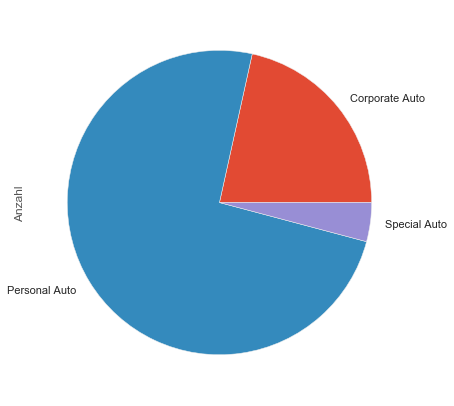

****************************************************************************************************

Anteil der Firmenwägen:	0.2154587256404642


In [43]:
column = 'Policy_Type'
univariat_analysis_categorical(df, column, 'pie', (7,7))
print("Anteil der Firmenwägen:\t{}".format(df[column].value_counts()['Corporate Auto']/df[column].count()))
if column in categorical_columns: categorical_columns.remove(column)

Wir sehen: 22% der versicherten Autos sind Firmenwägen - kommt es eventuell zu Überschneidungen zwischen Firmenwägen und Arbeitslosen? Dieser Frage werden wir bei den bivariaten Analysen nachgehen.

#### Weitere kategoriale Variablen

Hier wie angekündigt die verbleibenden Attribute.  
Schön ist auch hier zu sehen, wie die Plots der ordinalen Daten sortiert sind.

STATE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	3150
Häufigkeit des seltensten Wertes:	798


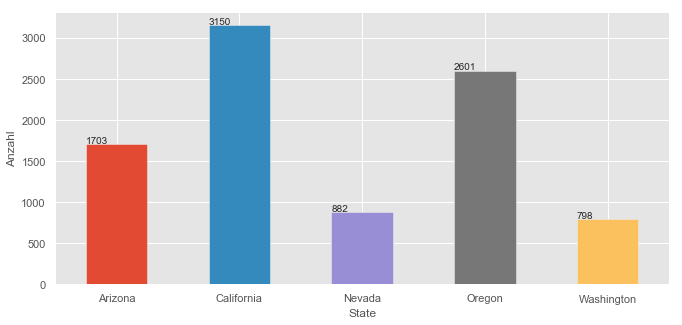

****************************************************************************************************

COVERAGE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	5568
Häufigkeit des seltensten Wertes:	824


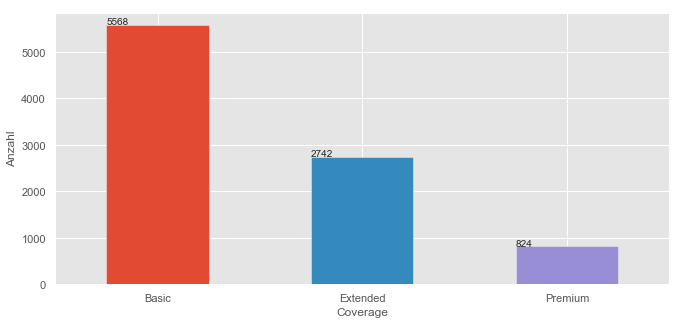

****************************************************************************************************

EDUCATION

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	2748
Häufigkeit des seltensten Wertes:	342


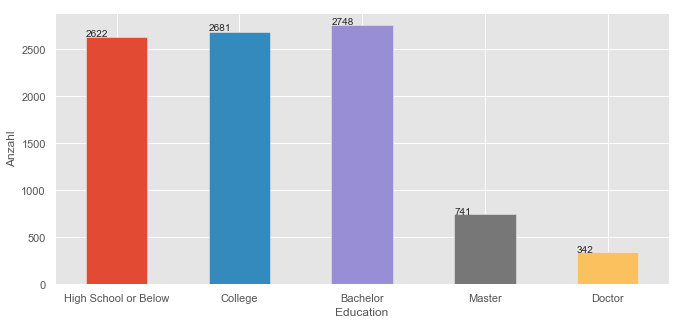

****************************************************************************************************

GENDER

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	4658
Häufigkeit des seltensten Wertes:	4476


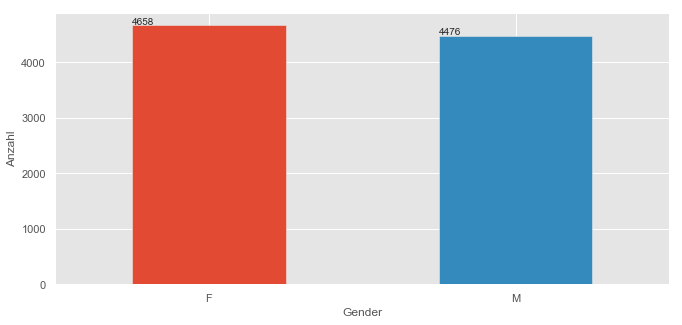

****************************************************************************************************

LOCATION_CODE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	5779
Häufigkeit des seltensten Wertes:	1582


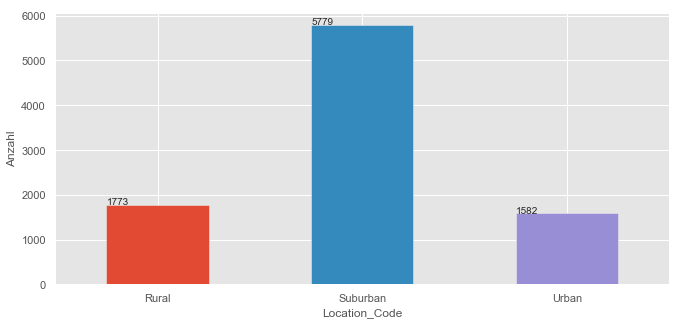

****************************************************************************************************

MARITAL_STATUS

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	5298
Häufigkeit des seltensten Wertes:	1369


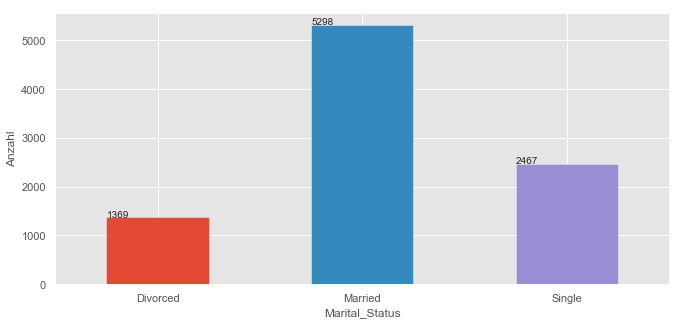

****************************************************************************************************

POLICY

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	3426
Häufigkeit des seltensten Wertes:	66


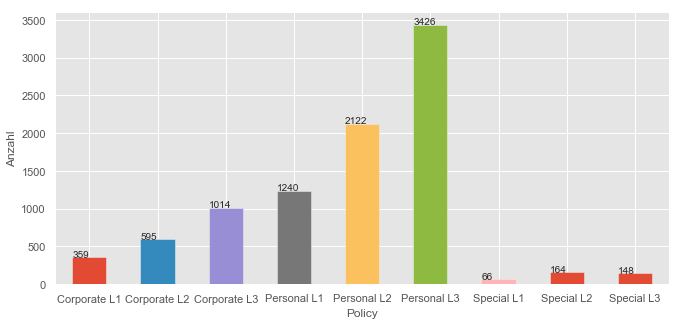

****************************************************************************************************

RENEW_OFFER_TYPE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	3752
Häufigkeit des seltensten Wertes:	1024


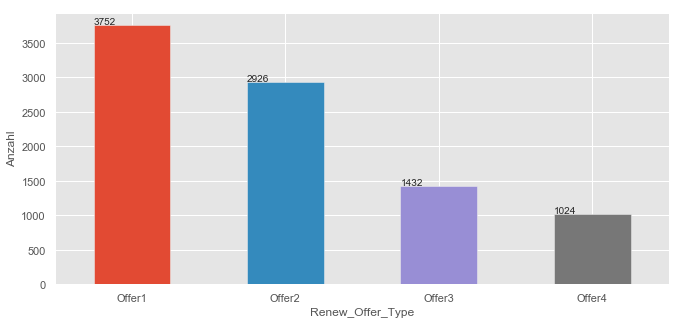

****************************************************************************************************

SALES_CHANNEL

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	3477
Häufigkeit des seltensten Wertes:	1325


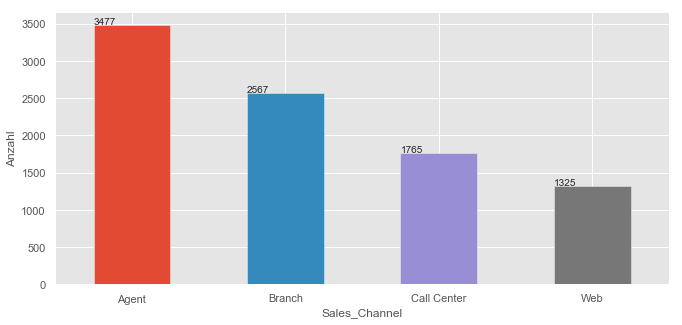

****************************************************************************************************

VEHICLE_CLASS

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	4621
Häufigkeit des seltensten Wertes:	163


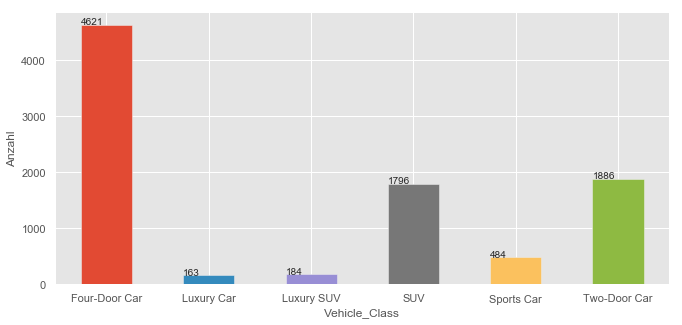

****************************************************************************************************

VEHICLE_SIZE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	6424
Häufigkeit des seltensten Wertes:	946


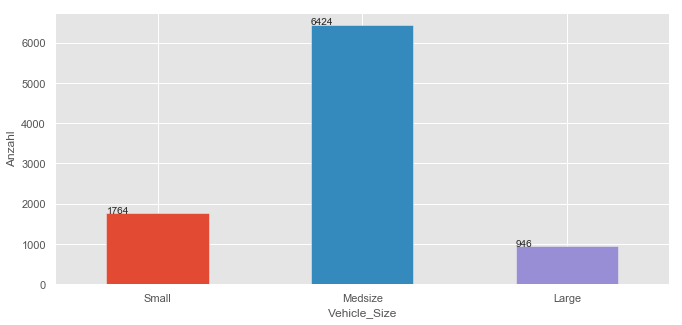

****************************************************************************************************



In [44]:
for column in categorical_columns:
    univariat_analysis_categorical(df, column)

### Timestamp

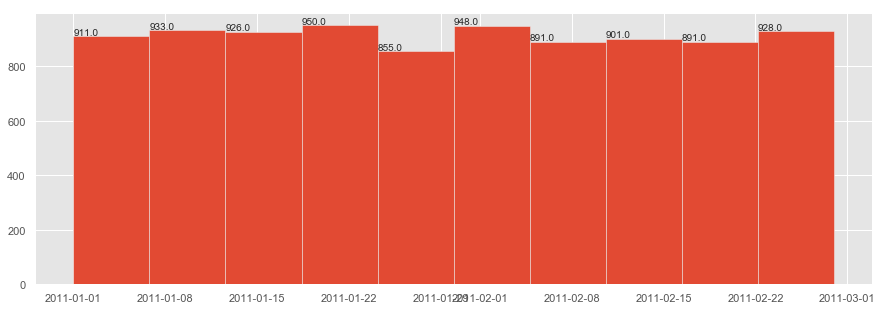

In [45]:
ax = df.Effective_To_Date.hist(figsize=(15,5))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.0, p.get_height() * 1.005))
plt.show()

__Wir sehen:__
+ Der Datenbestand umfasst zwei Monate.
+ Die Enddaten der Policen sind gleichverteilt, man kann also auch keinen Peak oder ähnliches zu Jahresbeginn feststellen.

__Daraus folgt:__  
+ Eine Zeitreihenanalyse ergibt für diesen kurzen Zeitraum keinen Sinn.

## Bi- und evtl multivariate Analysen

Im Folgenden betrachten wir die Variablen und ihre Wechselwirkungen untereinander.

### Kombination: _Employment Status_ und _Policy Type_

Wie bereits angesprochen interessiert uns, wie viele Policen wir an Arbeitslose ausgegeben haben - hier liegt eventuell eine Fehlerquelle oder Mißbrauch vor.

In [46]:
df[(df.Employment_Status=='Unemployed') & (df.Policy_Type=='Corporate Auto')].Customer_ID.count()

504

Hier sollten wir uns als Firma tatsächlich Gedanken machen - __da kann etwas nicht stimmen__.  
Für unsere weiteren Auswertungen ignorieren wir diesen Fakt.

### Scatterplot

Wir beginnen mit einem Scatterplot, der die einzelenen Attribute zueinander in Beziehung setzt.  
Können wir hier bereits eine Aussage über den weiteren Verlauf der Arbeit treffen?

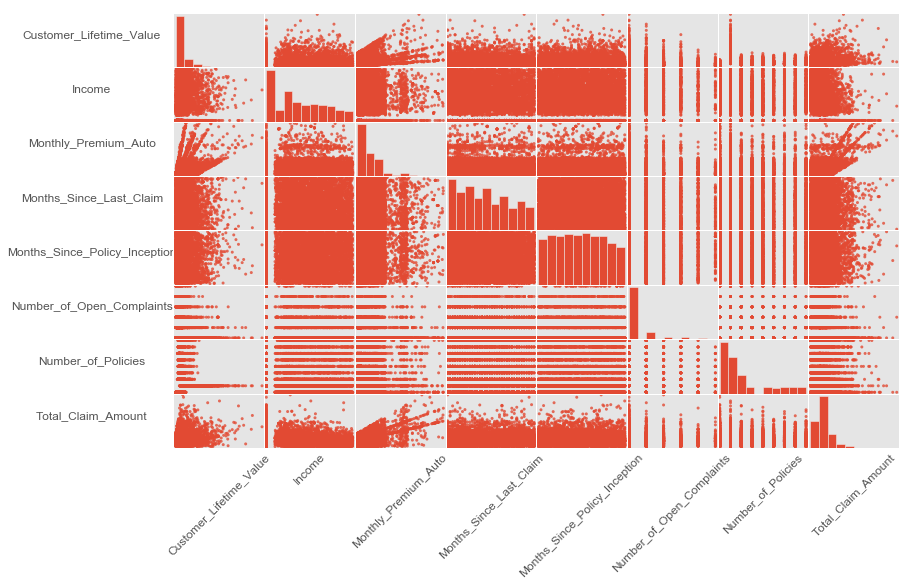

In [47]:
sm = pd.plotting.scatter_matrix(df, alpha=0.8, figsize=(13, 8))
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.get_yaxis().set_label_coords(-0.9,0.5) for s in sm.reshape(-1)]
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]
plt.show()

__Das sieht leider überhaupt nicht gut aus:__  
Wir können keinen einzigen linearen Zusammenhang ausmachen, an dem man sich für Prognosen eventuell festhalten könnte. Fast alle Scatterplots sehen aus, wie mit einem Schrotgewehr produziert.

### Korrelations-Matrix

Der nächste Schritt ist das Plotten der Korrelations-Matrix, eventuell können wir in den Zahlen bessere Informationen finden, als in der Visualisierung über einen Scatterplot.

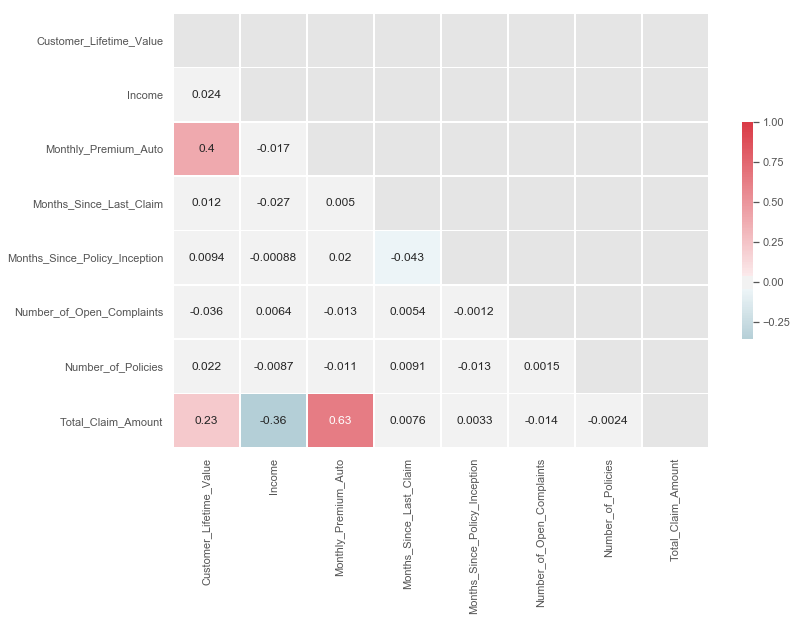

In [48]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, annot_kws={"size": 12}, square=False, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Leider finden sich hier __nur die numerischen Attribute__ und nicht wie erhofft auch die (ja dank Dictionary-Approch als ```int``` hinterlegten) kategorialen Attribute.  
Das __Einbeziehen der kategorialen Attribute__  ist umstritten, da auch bei Sortierung eine geeignete Abbildung über ```int``` nicht gewährleistet ist.  
__Ein Beispiel:__ Ist denn eine ```extended``` Deckung doppelt so viel "wert" wie eine ```basic```?

Trotzdem wollen wir es versuchen und wandeln in ```uint8``` um:

In [49]:
df_for_corr = df.copy()

df_for_corr.Coverage.cat.categories = [0,1,2]
df_for_corr.Coverage = df_for_corr.Coverage.astype('uint8')

df_for_corr.Education.cat.categories = [0,1,2,3,4]
df_for_corr.Education = df_for_corr.Education.astype('uint8')

df_for_corr.Vehicle_Size.cat.categories = [0,1,2]
df_for_corr.Vehicle_Size = df_for_corr.Vehicle_Size.astype('uint8')

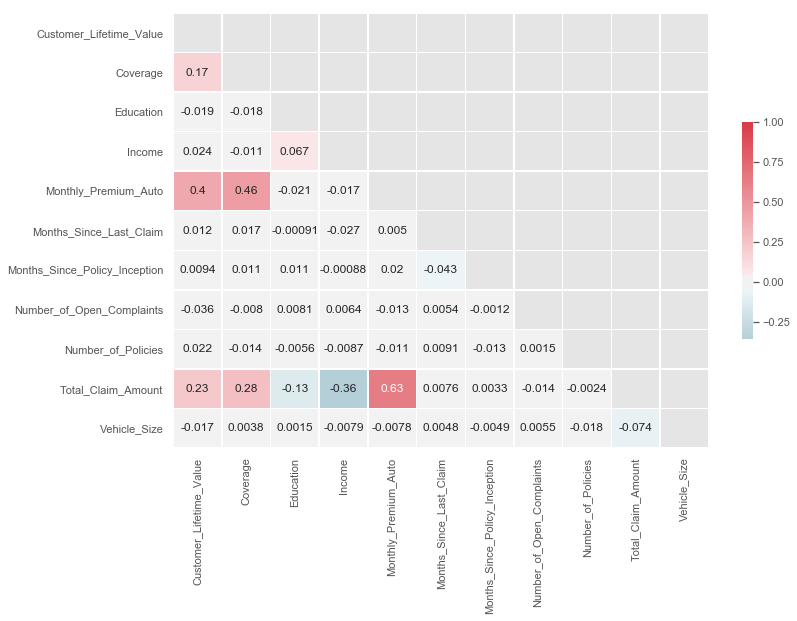

In [50]:
corr = df_for_corr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, annot_kws={"size": 12}, square=False, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

__Wir sehen:__
+ Unsere Zielvariable ```Customer_Lifetime_Value``` korreliert mit:
    + ```Monthly_Premium_Auto```
    + ```Total_Claim_Amount```
    + ```Coverage```
    + Dabei ist anzumerken, dass auch diese drei untereinander korrelieren - was bei fachlicher Betrachtung Sinn ergibt:
        + Wenn ein Fahrer eine hohe Schadenssumme verursacht, wird er eher gewillt sein, auf eine höhere Deckung umzusteigen - oder eventuell andersherum.
        + Wenn ein Fahrer eine hohe Schadenssumme verursacht, wird er von der Versicherung zu teureren Raten verdonnert, was wiederum potentiell in einem höheren Kundenwert resultiert.
+ Unsere Zielvariable ```Response``` ist nicht in der Korrelationsmatrix enthalten, da es sich um eine nominale Variable handelt. Daher müssen wir uns Zusammenhänge an dieser Front im nächsten Kapitel gesondert anschauen.
    
Generell ziehen wir als __Fazit__, dass eine __Modellierung nicht unbedingt erfolgsversprechend__ ist, uns aber eventuell wenigstens neue Einblicke in die Wichtigkeit der einzelnen Attribute über die Korrelationskoeffizeinten bzw die p-Werte gibt.

### Zusammenhang mit Zielvariablen für Klassifikation

Da die abhängige Variable für die Klassifikation, ```Response```, nominal ist, werden wir Interaktionen mit anderen Variablen im Folgenden visualisieren.

In [51]:
def plot_bivariate_numeric(dependent_column, df_p):
    for column in df_p.select_dtypes(include=np.number).columns.tolist():
        groups = df_p.groupby(dependent_column)[column]
        fig, ax = plt.subplots()
        for group, variable in groups:
            variable.hist(label=group, alpha=.5, ax=ax, figsize=(15,5))
        ax.legend()
        plt.title(column)
        plt.show()

In [52]:
def plot_bivariate_categorical(dependent_column, df_p):
    cat_columns_for_corr = df_p.select_dtypes(include="category").columns.tolist()
    cat_columns_for_corr.remove(dependent_column)
    for column in cat_columns_for_corr:
        plot_df = pd.DataFrame(df_p.groupby(by=[column, dependent_column])['Customer_ID'].count()).unstack()
        plot_df.columns = plot_df.columns.droplevel()
        plot_df.columns = plot_df.columns.astype('object')
        plot_df['total'] = plot_df.apply(lambda row: row.sum(), axis=1)
        for col in plot_df.columns:
            plot_df[col] = plot_df.apply(lambda row: row[col] / row.total, axis=1)
        plot_df.drop(columns='total', inplace=True)
        plot_df.plot(kind='bar', stacked=True, figsize=(15,5))
        plt.show()

#### Numerische Variablen

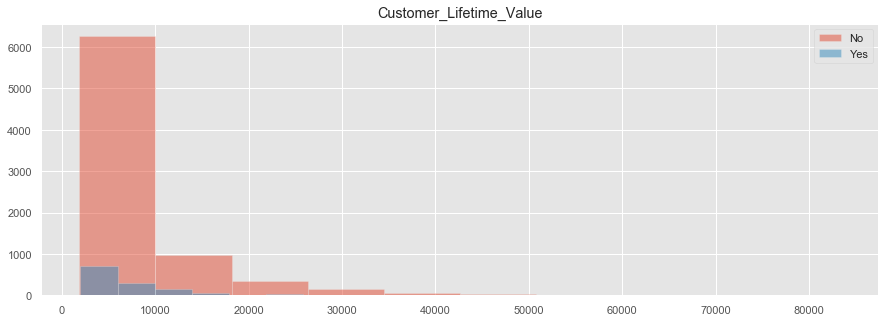

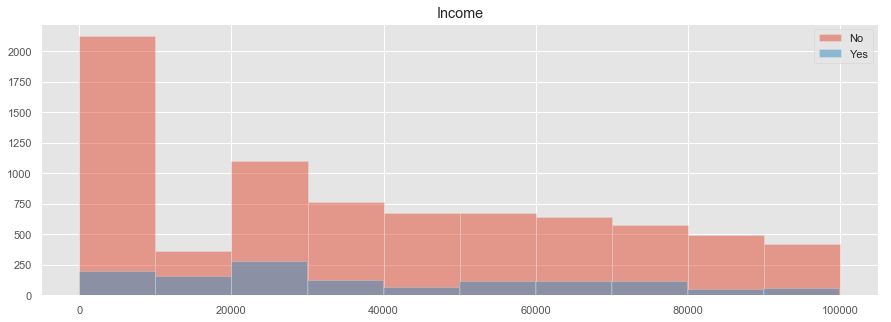

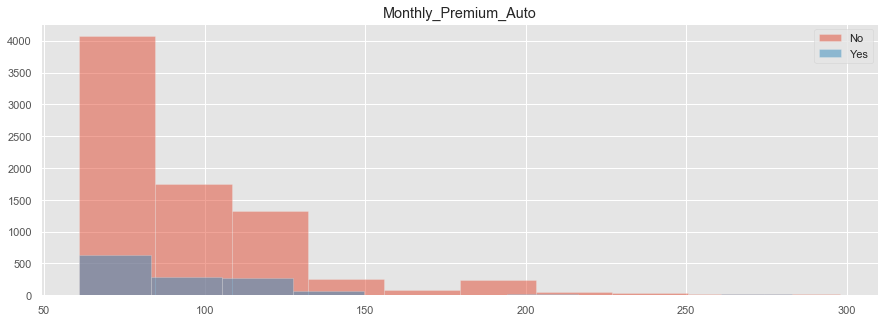

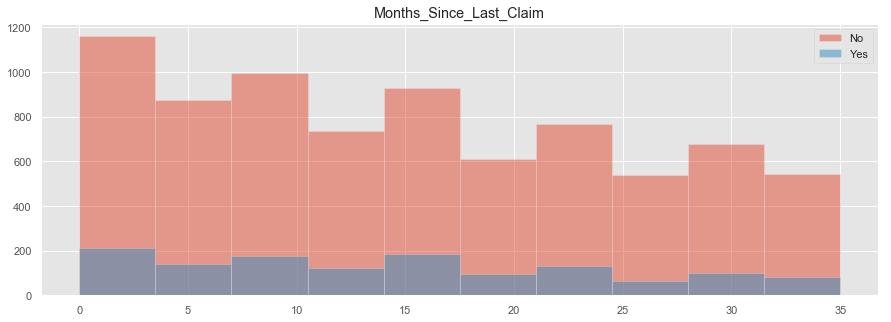

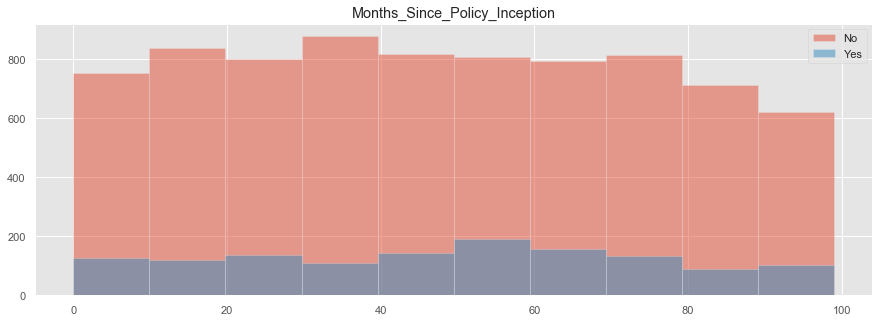

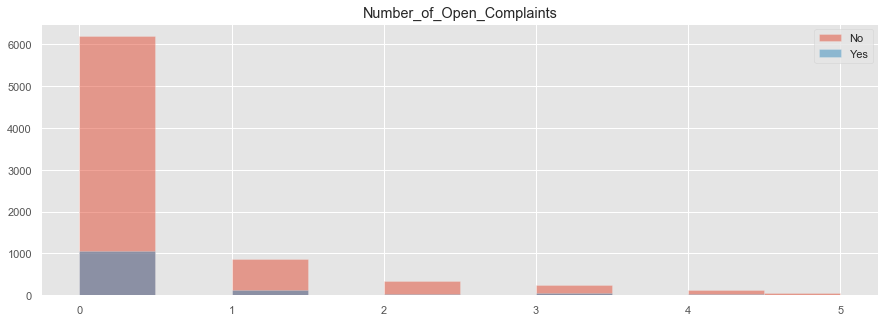

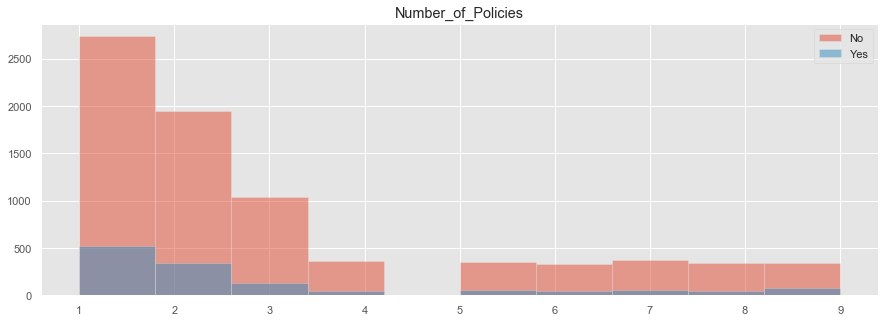

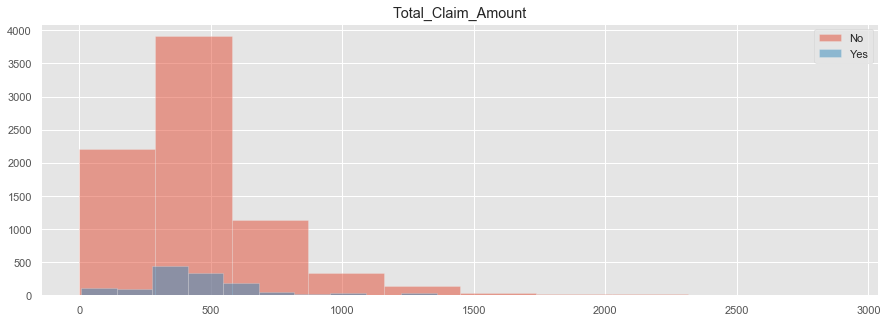

In [53]:
plot_bivariate_numeric('Response', df)

Wie wir sehen, scheint es __keine beachtenswerten Abweichungen zwischen den beiden Gruppen ```Yes``` und ```No```__ zu geben.  
Daraus lässt sich folgern, dass __keines der numerischen Attribute eine direkte Aussage über die Zielvariable__ zulässt.

#### Kategoriale Variablen

Da die kategorialen Daten sich weitaus besser vergleichen lassen, wenn die Balken jeweils die gleiche Höhe haben, haben wir jeweils die prozentuale Zusammensetzung des Ergebnisses visualisiert.  
Sobald eine Säule sichtbar von den anderen abweicht, lassen sich eventuell Rückschlüsse von der visualisierten Variablen auf die Zielvariable ableiten.

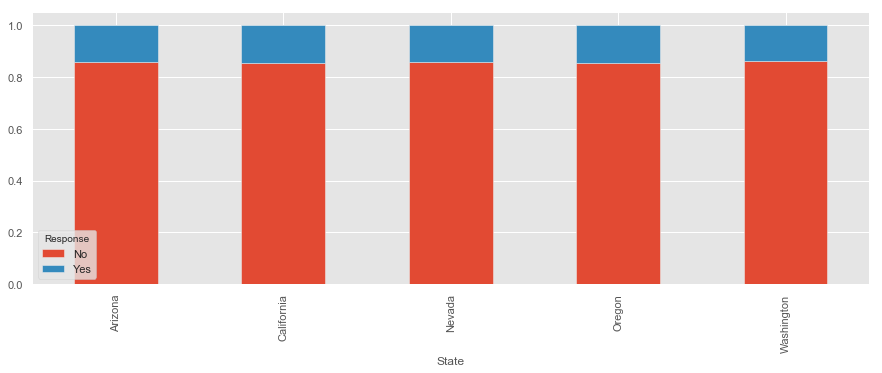

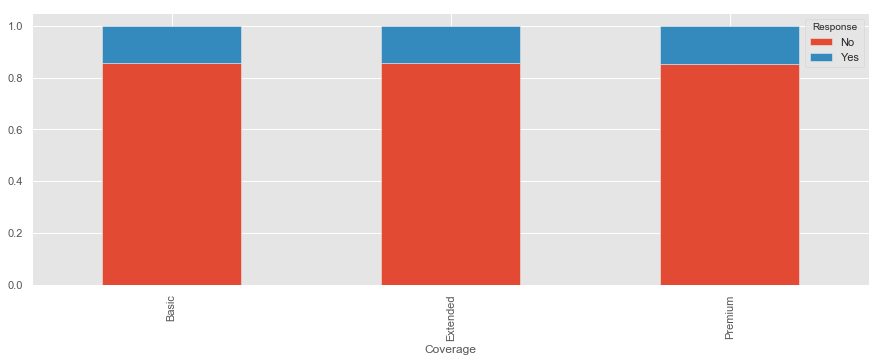

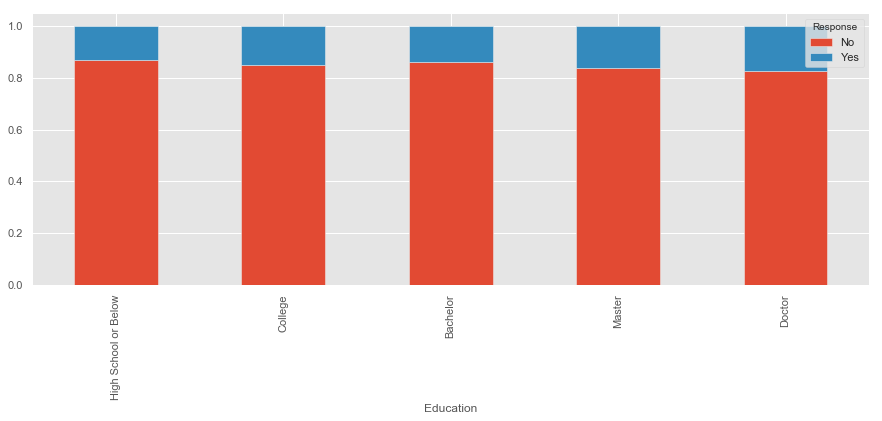

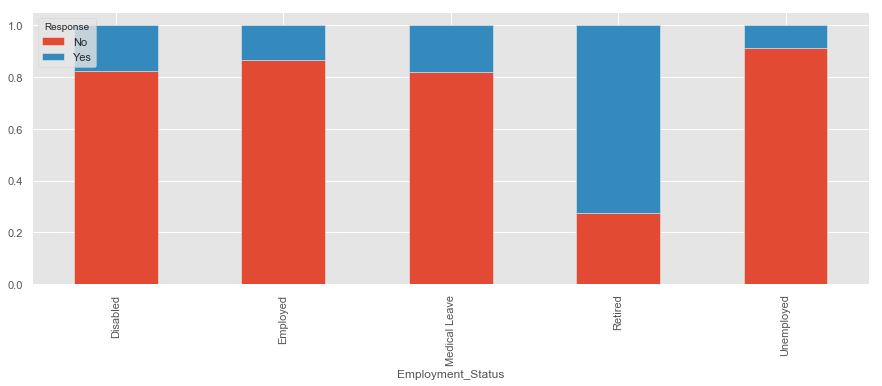

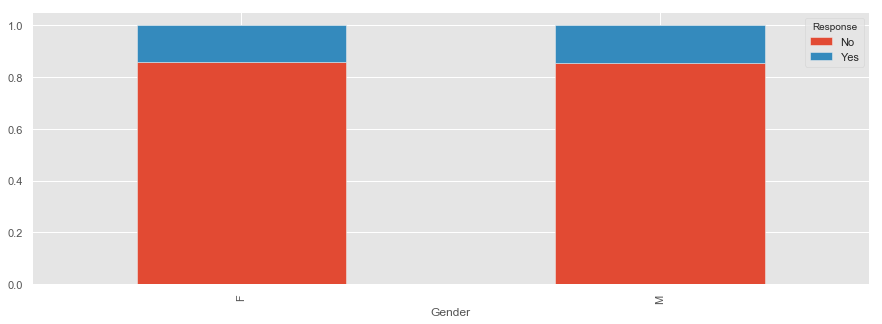

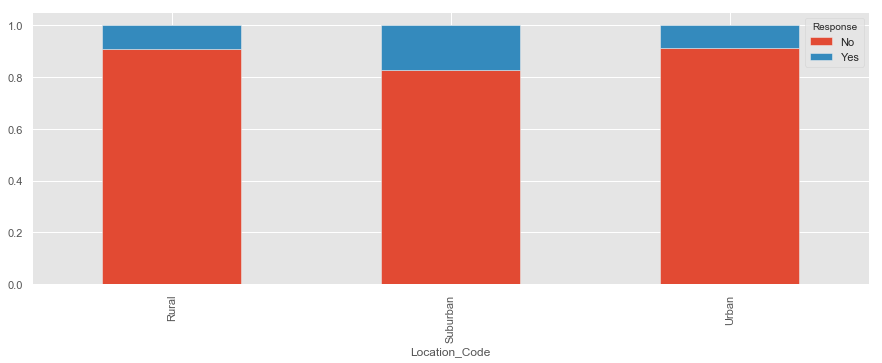

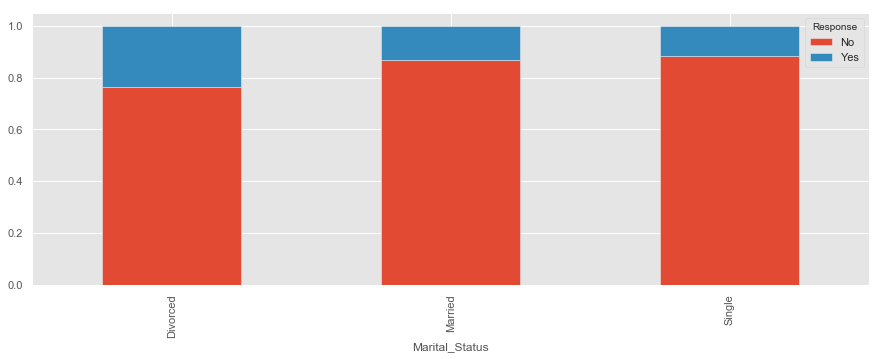

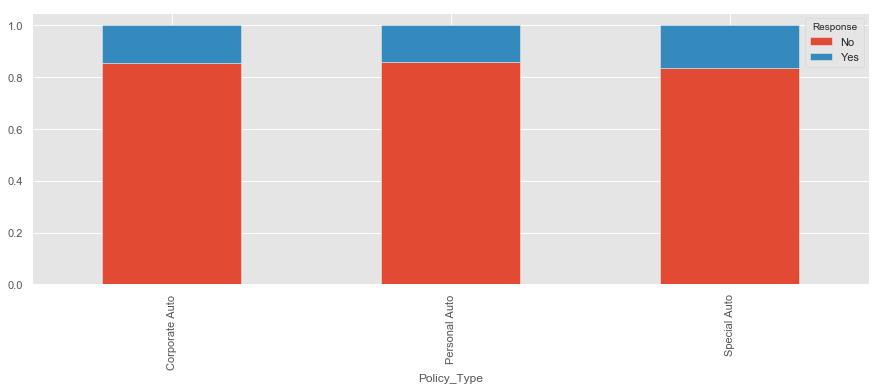

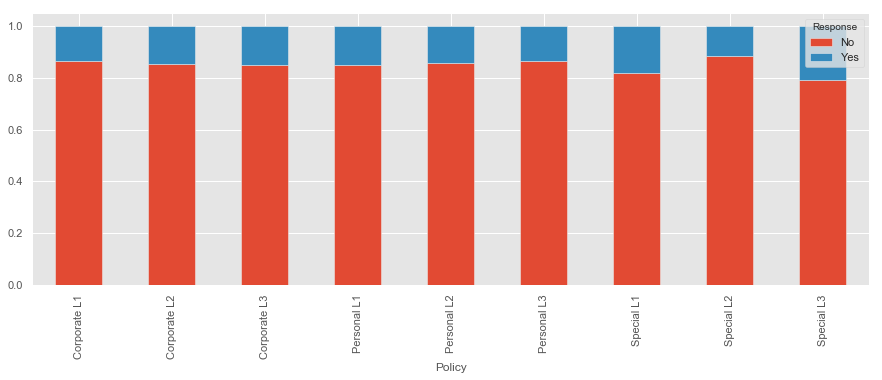

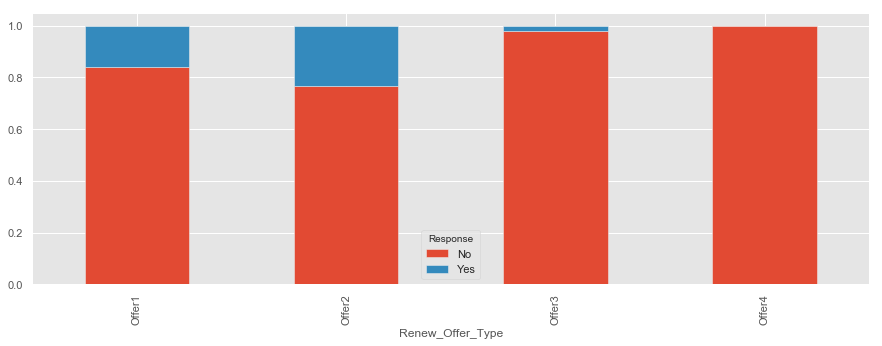

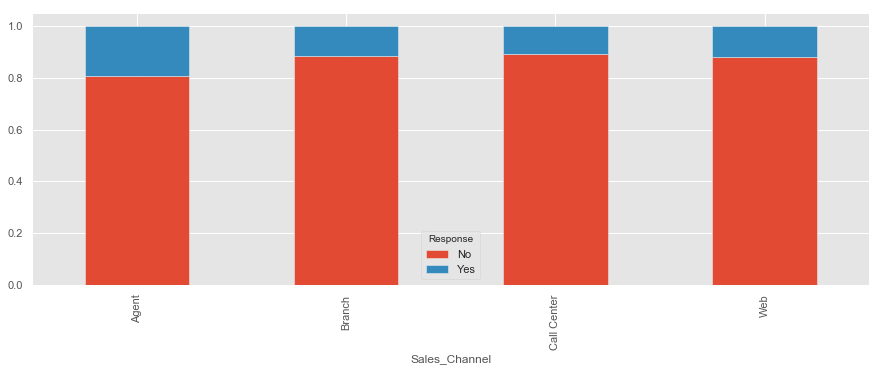

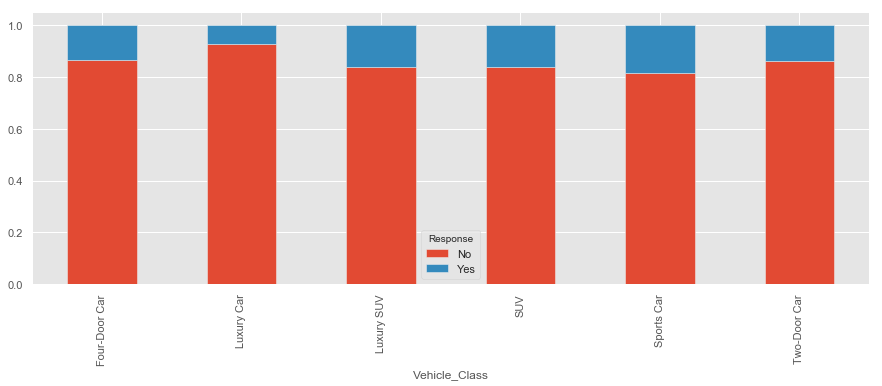

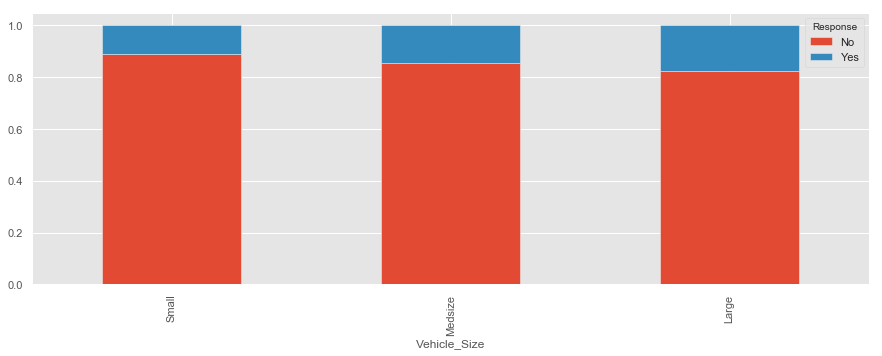

In [54]:
plot_bivariate_categorical('Response', df)

__Fazit:__  
+ ```Employment_Status: Retired```: wir können sehen, dass in der Gruppe der Rentner mehr Kunden antworten als nicht antworten. Diese Variable dürfte eine erhöhte Aussagekraft haben.
+ ```Marital_Status: Divorced```: hier ist der Unterschied längst nicht so groß, allerdings scheinen geschiedene Kunden im Vergleich besser auf unsere Kampagne reagiert zu haben.
+ ```Renew_Offer_Type```: ```Offer_2``` scheint relativ attraktiv gewesen zu sein, immerhin hat mehr als jeder Fünfte reagiert. ```Offer_1``` performte ähnlich gut, ```Offer_4``` produzierte offensichtlich kaum Antworten. Also dürfte auch das Wissen, welches Angebot wir verschickt haben uns einen Hinweis daruaf geben, ob sich der betrachtete Kunde zurückmelden wird.

## Regression: Customer Lifetime Value

Nachdem wir die uni- und bivariaten Analysen abgeschlossen haben und einen ungefähren Eindruch davon haben, was uns erwartet, wenden wir uns der Regression zu.  
Ziel ist es, für jeden Kunden den ```Customer_Lifetime_Value``` zu prognostizieren.

### One-Hot-Encoding

Da wir viele kategoriale Variablen im Datenbestand haben, erstellen wir einen neuen DataFrame, der sämtliche kategorialen Variablen als one-hot-encoded enthält:

In [55]:
df_ohe = pd.get_dummies(df, columns=df.select_dtypes(include="category").columns.tolist())
df_ohe.columns = df_ohe.columns.str.replace(' ', '')
df_ohe.columns = df_ohe.columns.str.replace('-', '_')

Wärend der originale DataFrame {{df.shape[1]}} Spalten enthält, wurden diese im OHE-DataFrame auf {{df_ohe.shape[1]}} aufgebohrt.

### Baseline: OLS mit statsmodels

Der erste Versuch der Modellierung erfolgt mit der Ordinary-Least-Squares-Methode.

#### Helper-Funktion

Patsy unterstützt keine Slicing-Operationen in den Formeln, Attribute müssen explizit angegeben werden.  
Um unvermeidbare Fehler zu verhindern, haben wir eine Funktion gebaut, die eine Liste von Attributen wahlweise mit Additionszeichen (für Patsy) oder mit Kommata separiert (für explizites Slicing) ausgibt:

In [56]:
def get_attributes_because_patsy_sucks(list_of_attributes, comma=True):
    string_to_copy = ""
    for attribute in list_of_attributes:
        if comma:
            string_to_copy = "{}, '{}'".format(string_to_copy, attribute)
        else:
            string_to_copy = "{} + {}".format(string_to_copy, attribute)
    return string_to_copy

In [57]:
get_attributes_because_patsy_sucks(df_ohe.columns.tolist())

", 'Customer_ID', 'Customer_Lifetime_Value', 'Effective_To_Date', 'Income', 'Monthly_Premium_Auto', 'Months_Since_Last_Claim', 'Months_Since_Policy_Inception', 'Number_of_Open_Complaints', 'Number_of_Policies', 'Total_Claim_Amount', 'State_Arizona', 'State_California', 'State_Nevada', 'State_Oregon', 'State_Washington', 'Response_No', 'Response_Yes', 'Coverage_Basic', 'Coverage_Extended', 'Coverage_Premium', 'Education_HighSchoolorBelow', 'Education_College', 'Education_Bachelor', 'Education_Master', 'Education_Doctor', 'Employment_Status_Disabled', 'Employment_Status_Employed', 'Employment_Status_MedicalLeave', 'Employment_Status_Retired', 'Employment_Status_Unemployed', 'Gender_F', 'Gender_M', 'Location_Code_Rural', 'Location_Code_Suburban', 'Location_Code_Urban', 'Marital_Status_Divorced', 'Marital_Status_Married', 'Marital_Status_Single', 'Policy_Type_CorporateAuto', 'Policy_Type_PersonalAuto', 'Policy_Type_SpecialAuto', 'Policy_CorporateL1', 'Policy_CorporateL2', 'Policy_Corporate

__Wichtig:__  
Wir entfernen die Attribute ```Renew_Offer```, ```Sales_Channel``` und ```Response``` für die Regression aus dem Datensatz, da diese keinen Einfluss auf den Kunden an sich haben sollten.  
Auch das Datum ```Effective_To_Date``` wird aufgrund der Erkenntnisse in der univariaten Analyse entfernt.

In [58]:
df_reg_v0 = df_ohe[['Customer_Lifetime_Value', 'Customer_ID', 'Income', 'Monthly_Premium_Auto',
                   'Months_Since_Last_Claim', 'Months_Since_Policy_Inception', 'Number_of_Open_Complaints',
                   'Number_of_Policies', 'Total_Claim_Amount', 'State_Arizona', 'State_California',
                   'State_Nevada', 'State_Oregon', 'State_Washington', 'Coverage_Basic', 'Coverage_Extended',
                   'Coverage_Premium', 'Education_HighSchoolorBelow', 'Education_College', 'Education_Bachelor',
                   'Education_Master', 'Education_Doctor', 'Employment_Status_Disabled',
                   'Employment_Status_Employed', 'Employment_Status_MedicalLeave', 'Employment_Status_Retired',
                   'Employment_Status_Unemployed', 'Gender_F', 'Gender_M', 'Location_Code_Rural',
                   'Location_Code_Suburban', 'Location_Code_Urban', 'Marital_Status_Divorced',
                   'Marital_Status_Married', 'Marital_Status_Single', 'Policy_Type_CorporateAuto',
                   'Policy_Type_PersonalAuto', 'Policy_Type_SpecialAuto', 'Policy_CorporateL1',
                   'Policy_CorporateL2', 'Policy_CorporateL3', 'Policy_PersonalL1', 'Policy_PersonalL2',
                   'Policy_PersonalL3', 'Policy_SpecialL1', 'Policy_SpecialL2', 'Policy_SpecialL3',
                   'Vehicle_Class_Four_DoorCar', 'Vehicle_Class_LuxuryCar', 'Vehicle_Class_LuxurySUV',
                   'Vehicle_Class_SUV', 'Vehicle_Class_SportsCar', 'Vehicle_Class_Two_DoorCar',
                   'Vehicle_Size_Small', 'Vehicle_Size_Medsize', 'Vehicle_Size_Large']]

Jetzt schreiben wir mithilfe von unserer Helper-Funktion die erste Formel:

In [59]:
get_attributes_because_patsy_sucks(df_reg_v0.columns.tolist(), comma=False)

' + Customer_Lifetime_Value + Customer_ID + Income + Monthly_Premium_Auto + Months_Since_Last_Claim + Months_Since_Policy_Inception + Number_of_Open_Complaints + Number_of_Policies + Total_Claim_Amount + State_Arizona + State_California + State_Nevada + State_Oregon + State_Washington + Coverage_Basic + Coverage_Extended + Coverage_Premium + Education_HighSchoolorBelow + Education_College + Education_Bachelor + Education_Master + Education_Doctor + Employment_Status_Disabled + Employment_Status_Employed + Employment_Status_MedicalLeave + Employment_Status_Retired + Employment_Status_Unemployed + Gender_F + Gender_M + Location_Code_Rural + Location_Code_Suburban + Location_Code_Urban + Marital_Status_Divorced + Marital_Status_Married + Marital_Status_Single + Policy_Type_CorporateAuto + Policy_Type_PersonalAuto + Policy_Type_SpecialAuto + Policy_CorporateL1 + Policy_CorporateL2 + Policy_CorporateL3 + Policy_PersonalL1 + Policy_PersonalL2 + Policy_PersonalL3 + Policy_SpecialL1 + Policy_S

In [60]:
formula_v0 = 'Customer_Lifetime_Value ~ Income + Monthly_Premium_Auto + Months_Since_Last_Claim + Months_Since_Policy_Inception + Number_of_Open_Complaints + Number_of_Policies + Total_Claim_Amount + State_Arizona + State_California + State_Nevada + State_Oregon + State_Washington + Coverage_Basic + Coverage_Extended + Coverage_Premium + Education_HighSchoolorBelow + Education_College + Education_Bachelor + Education_Master + Education_Doctor + Employment_Status_Disabled + Employment_Status_Employed + Employment_Status_MedicalLeave + Employment_Status_Retired + Employment_Status_Unemployed + Gender_F + Gender_M + Location_Code_Rural + Location_Code_Suburban + Location_Code_Urban + Marital_Status_Divorced + Marital_Status_Married + Marital_Status_Single + Policy_Type_CorporateAuto + Policy_Type_PersonalAuto + Policy_Type_SpecialAuto + Policy_CorporateL1 + Policy_CorporateL2 + Policy_CorporateL3 + Policy_PersonalL1 + Policy_PersonalL2 + Policy_PersonalL3 + Policy_SpecialL1 + Policy_SpecialL2 + Policy_SpecialL3 + Vehicle_Class_Four_DoorCar + Vehicle_Class_LuxuryCar + Vehicle_Class_LuxurySUV + Vehicle_Class_SUV + Vehicle_Class_SportsCar + Vehicle_Class_Two_DoorCar + Vehicle_Size_Small + Vehicle_Size_Medsize + Vehicle_Size_Large'

#### Modellierung des ersten Modells

In [61]:
ols_v0 = smf.ols(formula=formula_v0, data=df_reg_v0).fit()
ols_v0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Customer_Lifetime_Value   R-squared:                       0.165
Model:                                 OLS   Adj. R-squared:                  0.161
Method:                      Least Squares   F-statistic:                     43.76
Date:                     Wed, 12 Dec 2018   Prob (F-statistic):          5.69e-318
Time:                             06:21:12   Log-Likelihood:                -92837.
No. Observations:                     9134   AIC:                         1.858e+05
Df Residuals:                         9092   BIC:                         1.861e+05
Df Model:                               41                                         
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        482.3109    365.030      1.321      0.186    -233.231    1197.853
Income                            -0.0031      0.004     -0.809      0.418      -0.011       0.004
Monthly_Premium_Auto              69.8804     10.045      6.956      0.000      50.189      89.572
Months_Since_Last_Claim            7.9321      6.566      1.208      0.227      -4.939      20.803
Months_Since_Policy_Inception      0.4552      2.370      0.192      0.848      -4.190       5.100
Number_of_Open_Complaints       -233.1978     72.504     -3.216      0.001    -375.323     -91.073
Number_of_Policies                77.7035     27.640      2.811      0.005      23.523     131.884
Total_Claim_Amount                -0.3461      0.474     -0.730      0.465      -1.275       0.583
State_Arizona                     30.1602    157.529      0.191      0.848    -278.632     338.952
State_California                  64.4140    135.926      0.474      0.636    -202.031     330.859
State_Nevada                      69.5369    195.756      0.355      0.722    -314.189     453.263
State_Oregon                     111.3610    142.086      0.784      0.433    -167.159     389.881
State_Washington                 206.8387    204.488      1.011      0.312    -194.004     607.682
Coverage_Basic                    47.3440    145.623      0.325      0.745    -238.109     332.797
Coverage_Extended                191.9158    147.827      1.298      0.194     -97.859     481.690
Coverage_Premium                 243.0512    400.855      0.606      0.544    -542.716    1028.818
Education_HighSchoolorBelow      392.7418    150.814      2.604      0.009      97.113     688.371
Education_College                 59.1791    148.520      0.398      0.690    -231.953     350.311
Education_Bachelor                88.9647    148.429      0.599      0.549    -201.990     379.919
Education_Master                 184.4489    216.844      0.851      0.395    -240.614     609.512
Education_Doctor                -243.0236    293.832     -0.827      0.408    -819.000     332.953
Employment_Status_Disabled       -12.7827    282.158     -0.045      0.964    -565.876     540.311
Employment_Status_Employed       525.7702    199.927      2.630      0.009     133.869     917.672
Employment_Status_MedicalLeave   168.3130    275.708      0.610      0.542    -372.136     708.762
Employment_Status_Retired       -117.8428    328.222     -0.359      0.720    -761.231     525.546
Employment_Status_Unemployed     -81.1469    198.088     -0.410      0.682    -469.444     307.151
Gender_F                         334.2515    195.698      1.708      0.088     -49.360     717.863
Gender_M                         148.0594    192.801      

#### Bewertung des ersten Modells

__(adjusted) R-squared__:  
Der Wert von 0.161 sagt aus, dass wir 16% der Varianz der Daten mit unserem Modell erklären können. Dies ist offensichtlich kein besonders guter Wert, falls wir die Prognose in einem produktiven Einsatz zb zur Bewertung von Kundenwichtigkeit nutzen wollen.  

__F-Statistik (mit p-Value):__  
Der Wert von ```43.76``` ist ```> 0``` und sagt daher aus, dass das Modell statistisch gesehen signifikant ist. Der p_Wert von ```5.69e-318``` ist die Wahrscheinlichkeit, dass die Aussage der F-Statistik falsch ist (Null-Hypothese) - nachdem die Wahrscheinlichkeit extrem klein ist, verwerfen wir die Null-Hypothese und akzeptieren das Modell als statistisch signifikant.  

__ausgewählte beta-Parameter:__  
Jeden einzelnen beta-Parameter zu beschreiben würde hier den Platz sprengen. Wir beschränken uns daher auf zwei interessante Exemplare:
+ ```Intercept```: Der Wert ```482.3``` besagt, dass ein Kunde für den Fall, dass alle anderen Attribute "nicht erfüllt sind" einen Kundenwert von ```482.3 $``` hat. Allerdings ist der Parameter mit einem p-Value von ```0.186``` nicht statistisch signifikant (wir gehen immer von einer Grenze von ```0.05``` aus).
+ ```Number_of_Open_Complaints```: Falls die Anzahl der offenen Beschwerden ```0``` ist, wird der Koeffizient neutralisiert. Sobald aber offene Beschwerden vorliegen, verringert jede einzelne davon unseren Kundenwert um ```233.20 $```. Dies ist mit einem p-Value von ```0.001``` auch statistisch signifikant.  

__Standardfehler:__  
Die einzelen Koeffizienten haben jeweils noch die Angabe des Standardfehlers:
+ ```Number_of_Open_Complaints```: Der Standardfehler in Höhe von ```72.504``` ist die durchschnittliche Abweichung des geschätzten Parameterwerts vom wahren Parameterwert.

__AIC:__  
Informationskriterien helfen bei der Auswahl zwischen verschiedenen Modellen. Es geht dabei immer darum, die goldene Mitte (Ockhams Rasiermesser) zwischen hoher Realitätsnähe und niedriger Komplexität zu finden.

Das Akaike Information Criterium betrachtet die Parameteranzahl und die Modellkomplexität - je niedriger der Wert des AIC ist, desto besser. Es hat hier den Wert ```1.858e+05```. Spätere Modelle können dann über diesen Wert verglichen werden.

__BIC:__  
Ähnlich zum AIC ist das Bayesian Information Criterium aufgebaut, hier liegt der Wert bei ```1.861e+05```.

__Konfidenzintervall:__  
Zwischen die unteren und oberen Grenzen der Konfidenzintervalle fallen bei einem alpha-Wert von ```0.05``` ```95%``` der der Beobachtungen.  
Je näher die Grenzen beieinander liegen, desto stabiler ist damit der Wert.

In [62]:
ols_v0.conf_int(alpha=0.05)

,0,1
Intercept,-233.230873,1197.852703
Income,-0.010678,0.004437
Monthly_Premium_Auto,50.189181,89.571637
Months_Since_Last_Claim,-4.938993,20.803223
Months_Since_Policy_Inception,-4.189794,5.100244
Number_of_Open_Complaints,-375.322735,-91.072920
Number_of_Policies,23.523245,131.883776
Total_Claim_Amount,-1.275286,0.583048
State_Arizona,-278.631564,338.952022
State_California,-202.030905,330.858918


__Mean Squared Error (MSE):__  
Der MSE kann genutzt werden, um mehrere Modelle miteinander zu vergleichen.

In [63]:
ols_v0.mse_resid

39606644.00152897

#### Anpassung der Baseline über manuelle Feature Elimination

Für die nächsten beiden Versuche eliminieren wir jeweils alle Variablen des Vorgängermodells mit p-Values über ```0.05```:

##### Versuch 1

In [64]:
get_attributes_because_patsy_sucks(ols_v0.pvalues[ols_v0.pvalues<=0.05].index.tolist())

", 'Monthly_Premium_Auto', 'Number_of_Open_Complaints', 'Number_of_Policies', 'Education_HighSchoolorBelow', 'Employment_Status_Employed', 'Marital_Status_Divorced', 'Policy_Type_SpecialAuto', 'Policy_CorporateL1', 'Policy_CorporateL2', 'Vehicle_Size_Small'"

In [65]:
df_reg_v1 = df_ohe[['Customer_Lifetime_Value', 'Customer_ID', 'Monthly_Premium_Auto',
                    'Number_of_Open_Complaints', 'Number_of_Policies', 'Education_HighSchoolorBelow',
                    'Employment_Status_Employed', 'Marital_Status_Divorced', 'Policy_Type_SpecialAuto',
                    'Policy_CorporateL1', 'Policy_CorporateL2', 'Vehicle_Size_Small']]

In [66]:
get_attributes_because_patsy_sucks(ols_v0.pvalues[ols_v0.pvalues<=0.05].index.tolist(), comma=False)

' + Monthly_Premium_Auto + Number_of_Open_Complaints + Number_of_Policies + Education_HighSchoolorBelow + Employment_Status_Employed + Marital_Status_Divorced + Policy_Type_SpecialAuto + Policy_CorporateL1 + Policy_CorporateL2 + Vehicle_Size_Small'

In [67]:
formula_v1 = 'Customer_Lifetime_Value ~ Monthly_Premium_Auto + Number_of_Open_Complaints + Number_of_Policies + Education_HighSchoolorBelow + Employment_Status_Employed + Marital_Status_Divorced + Policy_Type_SpecialAuto + Policy_CorporateL1 + Policy_CorporateL2 + Vehicle_Size_Small'

In [68]:
ols_m_fe_v1 = smf.ols(formula=formula_v1, data=df_reg_v1).fit()
ols_m_fe_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Customer_Lifetime_Value   R-squared:                       0.162
Model:                                 OLS   Adj. R-squared:                  0.161
Method:                      Least Squares   F-statistic:                     176.3
Date:                     Wed, 12 Dec 2018   Prob (F-statistic):               0.00
Time:                             06:24:52   Log-Likelihood:                -92853.
No. Observations:                     9134   AIC:                         1.857e+05
Df Residuals:                         9123   BIC:                         1.858e+05
Df Model:                               10                                         
Covariance Type:                 nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     -34.5185    235.785     -0.146      0.884    -496.710     427.673
Monthly_Premium_Auto           79.0922      1.915     41.300      0.000      75.338      82.846
Number_of_Open_Complaints    -238.7529     72.384     -3.298      0.001    -380.641     -96.865
Number_of_Policies             77.2617     27.569      2.803      0.005      23.221     131.302
Education_HighSchoolorBelow   274.5552    146.087      1.879      0.060     -11.808     560.919
Employment_Status_Employed    587.6165    136.183      4.315      0.000     320.668     854.565
Marital_Status_Divorced       352.4434    184.854      1.907      0.057      -9.911     714.798
Policy_Type_SpecialAuto       636.7510    331.536      1.921      0.055     -13.134    1286.636
Policy_CorporateL1            452.4292    339.768      1.332      0.183    -213.592    1118.450
Policy_CorporateL2           -547.2128    267.790     -2.043      0.041   -1072.142     -22.284
Vehicle_Size_Small            116.2443    166.854      0.697      0.486    -210.827     443.315
==============================================================================
Omnibus:                     5671.634   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65079.611
Skew:                           2.853   Prob(JB):                         0.00
Kurtosis:                      14.766   Cond. No.                         524.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Versuch 2

In [69]:
get_attributes_because_patsy_sucks(ols_m_fe_v1.pvalues[ols_m_fe_v1.pvalues<=0.05].index.tolist())

", 'Monthly_Premium_Auto', 'Number_of_Open_Complaints', 'Number_of_Policies', 'Employment_Status_Employed', 'Policy_CorporateL2'"

In [70]:
df_reg_v2 = df_ohe[['Customer_Lifetime_Value', 'Customer_ID', 'Monthly_Premium_Auto',
                    'Number_of_Open_Complaints', 'Number_of_Policies', 'Employment_Status_Employed',
                    'Policy_CorporateL2']]

In [71]:
get_attributes_because_patsy_sucks(ols_m_fe_v1.pvalues[ols_m_fe_v1.pvalues<=0.05].index.tolist(), comma=False)

' + Monthly_Premium_Auto + Number_of_Open_Complaints + Number_of_Policies + Employment_Status_Employed + Policy_CorporateL2'

In [72]:
formula_v2 = 'Customer_Lifetime_Value ~ Monthly_Premium_Auto + Number_of_Open_Complaints + Number_of_Policies + Employment_Status_Employed + Policy_CorporateL2'

In [74]:
ols_m_fe_v2 = smf.ols(formula=formula_v2, data=df_reg_v2).fit()
ols_m_fe_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Customer_Lifetime_Value   R-squared:                       0.161
Model:                                 OLS   Adj. R-squared:                  0.160
Method:                      Least Squares   F-statistic:                     349.8
Date:                     Wed, 12 Dec 2018   Prob (F-statistic):               0.00
Time:                             06:26:57   Log-Likelihood:                -92859.
No. Observations:                     9134   AIC:                         1.857e+05
Df Residuals:                         9128   BIC:                         1.858e+05
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    170.8815    226.793      0.753      0.451    -273.684     615.447
Monthly_Premium_Auto          79.1598      1.915     41.334      0.000      75.406      82.914
Number_of_Open_Complaints   -242.1528     72.392     -3.345      0.001    -384.057    -100.249
Number_of_Policies            76.4853     27.567      2.775      0.006      22.448     130.522
Employment_Status_Employed   577.6941    136.005      4.248      0.000     311.093     844.295
Policy_CorporateL2          -603.7773    267.051     -2.261      0.024   -1127.257     -80.298
==============================================================================
Omnibus:                     5670.152   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            64828.380
Skew:                           2.854   Prob(JB):                         0.00
Kurtosis:                      14.737   Cond. No.                         405.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Bewertung der drei Versuche mit OLS

__Vergleich von R-squared und F-Test:__

Links Versuch 1 mit allen Attributen, mitte Versuch 2 mit manueller Feature-Eliminiation, rechts Versuch 3 mit manueller Feature-Eliminiation:
<img src="./pictures/vergleich_ols.jpg" alt="drawing" width="600"/>

__Wir sehen:__  
Das adjusted R-squared verliert im dritten Versuch auf der dritten Nachkommastelle.  
Der Wert der F-Statistik wächst immer mehr, die Modelle werden also immer statistisch signifikanter.  
AIC und BIC verändern sich fast nicht.

__Verleich der drei MSEs:__

In [75]:
print("Modell 1:\t{}".format(ols_v0.mse_resid))
print("Modell 2:\t{}".format(ols_m_fe_v1.mse_resid))
print("Modell 3:\t{}".format(ols_m_fe_v2.mse_resid))

Modell 1:	39606644.00152897
Modell 2:	39607656.205343775
Modell 3:	39640156.04297143


Der MSE steigt minimal an, die Modelle werden also tendenziell eher schlechter denn besser.

#### Festlegung der Baseline

Wir entscheiden und für das Modell ```ols_m_fe_v1```, da hier das adjusted R-squared noch bei ```0.161``` liegt und sich der Anstieg des MSE verkraften lässt. Zudem können wir uns so auf eine kleinere Auswahl von beta-Parametern konzentrieren:  
<img src="./pictures/vgl_korrelation_beta.jpg" alt="drawing" width="600"/>

__Betrachtung einer Auswahl an Koeffizienten__

__Positive Koeffizienten:__  
+ ```Monthly_Premium_Auto```: Wie erwartet bei einer Korrelation von ```0.4``` fließt der Paramter ins Modell ein mit dem Koeffizienten von ```79``` und einem vergleichsweise niedrigen Standardfehler von ```1.9```. Allerdings sollte man keine Korrelationsmatrix oder Modell benötigen, um hier einen Zusammenhang feststellen zu können.  
+ ```Total_Claim_Amount```: Entgegen den Erwartungen aus der Korrelationsmatrix hat es dieses Attribut nicht in die Feature-Auswahl geschafft.  
+ ```Coverage```: Auch die Coverage hat nach dem OHE keine genügend hohe Signifikanz mehr für die Auswahl.
+ ```Employment_Status_Employed```: Dieses Feature fließt mit einer sehr hohen Signifikant (p-Wert bei ```0```) ein. Dabei hat das Attribut mit einem Koeffizienten von ```588``` und einer gemäßigten Streuung einen sehr starken Einfluß auf das Regressionsergebnis.  

__Negative Koeefizienten:__  
+ ```Policy_CorporateL2```: Mit einem Wert von ```-547``` vermindert dieses Attribut das Ergebnis gewaltig, wenn eine L2-Police vorliegt. Allerdings verursacht der Standardfehler von ```268``` eine starke Streuung. Anscheinend ist diese Art der Police keine gute Art, unsere Kunden zu halten oder zu monetarisieren.
+ ```Number_of_Open_Complaints```: Auch die offenen Beschwerden beeinflussen nachvollziehbarerweise unseren Kundenwert negativ.

### Untersuchung der Ausreißer

Nachdem wir sehen, dass die Modelle nicht sonderlich erfolgreich prognostizieren, wollen wir uns die Ausreißer genauer anschauen und prüfen, ob sie einen starken Einfluss aufs Modell haben.

#### Plotting-Helper

Um später weniger störenden Code im Notebook zu haben, schreiben wir uns hier eine Helper-Funktion fürs Plotting:

In [76]:
def plot_diagnostic_plots(model, df=None, dependent_variable=None, res_lev=False, res_fit=False, qq=False, scale_loc=False):
    # Residuals vs. Leverage
    if res_lev:
        print("-"*50)
        print('Residuals vs. Leverage')
        fig, ax = plt.subplots(figsize=(8,6))
        fig = plot_leverage_resid2(model, ax = ax)
        plt.show()
    # Residuals vs. Fitted
    if res_fit:
        print("-"*50)
        print('Residuals vs. Fitted')
        try:
            plot = sns.residplot(model.fittedvalues, dependent_variable, data=df, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'black', 'lw': 1, 'alpha': 0.8})
            plot.set_title('Residuals vs Fitted')
            plot.set_xlabel('Fitted values')
            plot.set_ylabel('Residuals')
            plt.show()
        except:
            print("Für Residuals vs Fitted werden ein DataFrame und die Zielvariable benötigt. Bitte nachreichen.")
    # Q-Q-Plot
    if qq:
        print("-"*50)
        print('Q-Q-Plot')
        stopbuggingme.qqplot(model.get_influence().resid_studentized_internal, line='45')
        plt.show()
    # Scale-Location
    if scale_loc:
        print("-"*50)
        print('Scale-Location')
        plt.scatter(model.fittedvalues, np.sqrt(np.abs(model.get_influence().resid_studentized_internal)), alpha=0.5)
        sns.regplot(model.fittedvalues, np.sqrt(np.abs(model.get_influence().resid_studentized_internal)), scatter=False, ci=False, lowess=True, line_kws={'color': 'blue', 'lw': 1, 'alpha': 0.8})
        plt.show()

#### Residual-vs-Leverage-Plot

--------------------------------------------------
Residuals vs. Leverage


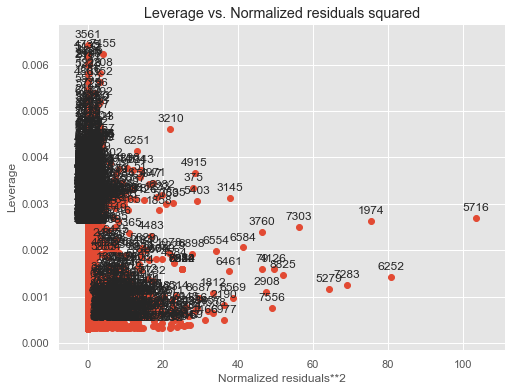

In [77]:
plot_diagnostic_plots(ols_m_fe_v1, res_lev=True)

__Wir sehen:__  
Es gibt einige wenige Werte, die aus der dichten Wolke am linken Rand herausstechen. Diese haben zwar keinen ganz großen Einfluss aufs Modell (Leverage), allerdings sollten wir sie genauer betrachten.

#### Betrachtung der Werte

Der durchschnittliche Kundenwert ist:

In [78]:
df_reg_v1.Customer_Lifetime_Value.mean()

8004.9404

Und diese Werte haben unsere Top-20-Kunden:

In [80]:
df_reg_v1.Customer_Lifetime_Value.sort_values(ascending=False).head(21)

5716    83325.382812
1974    74228.515625
6252    73225.953125
7283    67907.273438
5279    66025.757812
7303    64618.757812
3760    61850.187500
8825    61134.683594
4126    60556.191406
2908    58753.878906
6584    58207.128906
79      58166.554688
7556    57520.500000
4915    56675.937500
6461    55277.445312
3145    52811.492188
6554    51426.250000
2190    51337.906250
6569    51016.066406
7835    50568.257812
6977    49423.796875
Name: Customer_Lifetime_Value, dtype: float32

Dass hier das Ergebnis stark verfälscht wird, haben wir bereits in den univariaten Anaylse vermutet.  
Wir wollen die obersten Ausreißer also im nächsten Schritt entfernen.

#### Ausschließen der Ausreißer

Dazu entfernen wir alle Kunden, deren Kundenwert größer als ```50000 $``` ist, diese decken sich relativ gut mit den IDs in der Grafik oben:

In [81]:
df_reg_v1_less_outliers = df_reg_v1[df_reg_v1.Customer_Lifetime_Value<50000]

#### Erneutes Training mit OLS

Nun trainieren wir erneut mit den verbleibenden Kuden:

In [82]:
ols_m_fe_v1_less_outliers = smf.ols(formula=formula_v1, data=df_reg_v1_less_outliers).fit()
ols_m_fe_v1_less_outliers.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Customer_Lifetime_Value   R-squared:                       0.144
Model:                                 OLS   Adj. R-squared:                  0.143
Method:                      Least Squares   F-statistic:                     153.5
Date:                     Wed, 12 Dec 2018   Prob (F-statistic):          6.43e-299
Time:                             06:31:25   Log-Likelihood:                -92106.
No. Observations:                     9114   AIC:                         1.842e+05
Df Residuals:                         9103   BIC:                         1.843e+05
Df Model:                               10                                         
Covariance Type:                 nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     661.1370    223.231      2.962      0.003     223.555    1098.719
Monthly_Premium_Auto           69.8489      1.827     38.239      0.000      66.268      73.430
Number_of_Open_Complaints    -236.0902     68.241     -3.460      0.001    -369.857    -102.323
Number_of_Policies             93.0469     25.977      3.582      0.000      42.126     143.968
Education_HighSchoolorBelow   300.9523    137.768      2.184      0.029      30.896     571.009
Employment_Status_Employed    577.7870    128.434      4.499      0.000     326.028     829.546
Marital_Status_Divorced       467.8794    174.189      2.686      0.007     126.430     809.328
Policy_Type_SpecialAuto       752.6237    312.366      2.409      0.016     140.317    1364.931
Policy_CorporateL1            571.1980    320.122      1.784      0.074     -56.312    1198.708
Policy_CorporateL2           -485.6608    252.512     -1.923      0.054    -980.641       9.320
Vehicle_Size_Small             47.2124    157.442      0.300      0.764    -261.409     355.834
==============================================================================
Omnibus:                     4883.968   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33877.251
Skew:                           2.545   Prob(JB):                         0.00
Kurtosis:                      10.956   Cond. No.                         522.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__Fazit:__  
Leider hat sich das Ergebnis verschlechtert, wenn man den __adjusted R-Squared-Wert__ betrachtet. Dieser hat zur BAseline um fast ```0.02``` nachgelassen.  
Positiv ist zu vermerken, dass der __MSE__  um ein ganzes Stück geringer geworden ist:

In [83]:
print("Baseline:\t\t\t{}".format(ols_m_fe_v1.mse_resid))
print("Modell mit weniger Ausreißern:\t{}".format(ols_m_fe_v1_less_outliers.mse_resid))

Baseline:			39607656.205343775
Modell mit weniger Ausreißern:	35155258.747672684


#### Erneuter Residual-vs-Leverage-Plot mit weniger Ausreißern

Auf dem Plot sieht man die fehlenden Ausreißer:

--------------------------------------------------
Residuals vs. Leverage


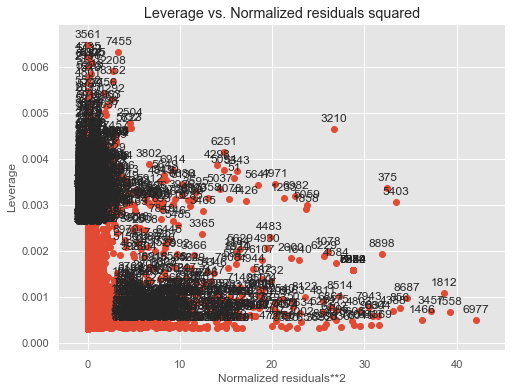

In [84]:
plot_diagnostic_plots(ols_m_fe_v1_less_outliers, res_lev=True)

### Lasso

Nachdem wir mit OLS nur sehr mittelprächtige Ergebnisse erzielen konnten, wollen wir unser Glück mit Lasso versuchen.

#### Erster Versuch mit Baseline-Features mit allen Datensätzen

Wir erstellen uns einen neuen DataFrame mit den Attributen des Baseline-Modells:

In [85]:
df_lasso_v1 = df_reg_v1.select_dtypes(np.number)

In [86]:
X = np.array(df_lasso_v1.iloc[:,1:])
y = np.array(df_lasso_v1.iloc[:,0])

Jetzt trainiern wir in fünf Folds mit 100 verschiedenen alpha-Werten, um einen möglichst guten Wert für diesen Hyperparameter zu finden:

In [87]:
clf = LassoCV(cv=5, n_alphas=100, normalize=True, n_jobs=-1, random_state=1)

In [88]:
clf.fit(X, y)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=-1, normalize=True, positive=False,
    precompute='auto', random_state=1, selection='cyclic', tol=0.0001,
    verbose=False)

Das beste Modell hat ein R-squared von ```0.162``` und stellt damit eine minimale Verbesserung gegenüber der Baseline mit ```0.161``` dar:

In [89]:
clf.score(X,y)

0.1619529654739266

Dieses Ergebnis wird mit folgendem alpha-Wert erreicht:

In [90]:
clf.alpha_

0.02848693741760513

Interessant ist, dass in diesem Modell jeder Kunde erstmal einen negativen Kundenwert hat:

In [91]:
clf.intercept_

-16.337646972400762

#### Erneuter Versuch mit Baseline-Features mit weniger Ausreißern

Können wir hier das Ergebnis verbessern, wenn wir die Ausreißer entfernen?

In [92]:
df_lasso_v1_less_outliers = df_reg_v1_less_outliers.select_dtypes(np.number)

In [93]:
X = np.array(df_lasso_v1_less_outliers.iloc[:,1:])
y = np.array(df_lasso_v1_less_outliers.iloc[:,0])

In [94]:
clf = LassoCV(cv=5, n_alphas=100, normalize=True, n_jobs=-1, random_state=1)

In [95]:
clf.fit(X, y)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=-1, normalize=True, positive=False,
    precompute='auto', random_state=1, selection='cyclic', tol=0.0001,
    verbose=False)

Die Antwort ist klar: __nein__, das Modell wird sogar schlechter:

In [96]:
clf.score(X,y)

0.14431689175247187

#### Manueller Versuch

Wir fragen uns, ob wir mit einem manuellen Tuning von alpha besser fahren:

In [97]:
df_lasso_v0 = df_reg_v0.select_dtypes(np.number)
df_lasso_v0.name = 'v0'

df_lasso_v1 = df_reg_v1.select_dtypes(np.number)
df_lasso_v1.name = 'v1'

df_lasso_v2 = df_reg_v2.select_dtypes(np.number)
df_lasso_v2.name = 'v2'

lasso_data = [df_lasso_v0, df_lasso_v1, df_lasso_v2]

In [98]:
alphas = [1,2,10,25,50,75,100,200]
df_lasso_r2 = pd.DataFrame(columns=['r2_train_v0','r2_test_v0',
                                    'r2_train_v1','r2_test_v1',
                                    'r2_train_v2','r2_test_v2'])

coef_dict = {}
for df_lasso in lasso_data:
    X = np.array(df_lasso.iloc[:,1:])
    y = np.array(df_lasso.iloc[:,0])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.75, test_size=0.25, random_state=1)
    
    lasso = Lasso(alpha=2)
    lasso.fit(X_train,y_train)
    print("R^2 der Trainingsdaten: ("+df_lasso.name+") \t\t",lasso.score(X_train,y_train))
    print("R^2 der Testdaten: ("+df_lasso.name+") \t\t", lasso.score(X_test,y_test))
    
    for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(X_train,y_train)
        d1 = {'alpha':alpha,'r2_train_'+df_lasso.name:lasso.score(X_train,y_train),'r2_test_'+df_lasso.name:lasso.score(X_test,y_test)}
        df_lasso_r2 = df_lasso_r2.append(d1,ignore_index=True)
    
    best_alpha = df_lasso_r2[df_lasso_r2['r2_test_'+df_lasso.name]==df_lasso_r2['r2_test_'+df_lasso.name].max()]['alpha'].values.item()
    print("Bester alpha Wert ("+df_lasso.name+"): \t\t",best_alpha)
    lasso.set_params(alpha = best_alpha)
    lasso.fit(X_train,y_train)
    
    coef_dict[df_lasso.name] = pd.Series(lasso.coef_, df_lasso.columns[1:])

R^2 der Trainingsdaten: (v0) 		 0.16776232852349326
R^2 der Testdaten: (v0) 		 0.1477253013672274
Bester alpha Wert (v0): 		 75.0
R^2 der Trainingsdaten: (v1) 		 0.16490400429521268
R^2 der Testdaten: (v1) 		 0.14868548418373362
Bester alpha Wert (v1): 		 100.0
R^2 der Trainingsdaten: (v2) 		 0.16288122150308793
R^2 der Testdaten: (v2) 		 0.1515043587606747
Bester alpha Wert (v2): 		 50.0


/Users/DE2303318/miniconda3/envs/statistics/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/DE2303318/miniconda3/envs/statistics/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/DE2303318/miniconda3/envs/statistics/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/DE2303318/miniconda3/envs/statistics/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [97]:
df_lasso_r2.groupby('alpha').mean()

,r2_train_v0,r2_test_v0,r2_train_v1,r2_test_v1,r2_train_v2,r2_test_v2
alpha,,,,,,
1.0,0.167769,0.147659,0.164905,0.148642,0.162882,0.151492
2.0,0.167762,0.147725,0.164904,0.148685,0.162881,0.151504
10.0,0.167668,0.148448,0.164884,0.149019,0.162871,0.151591
25.0,0.167332,0.149619,0.164776,0.149562,0.162816,0.151711
50.0,0.166444,0.150872,0.164391,0.150232,0.162619,0.151785
75.0,0.165291,0.151074,0.163749,0.150606,0.162290,0.151702
100.0,0.164086,0.150958,0.162908,0.150639,0.161831,0.151461
200.0,0.159784,0.149827,0.159276,0.149622,0.159235,0.149652


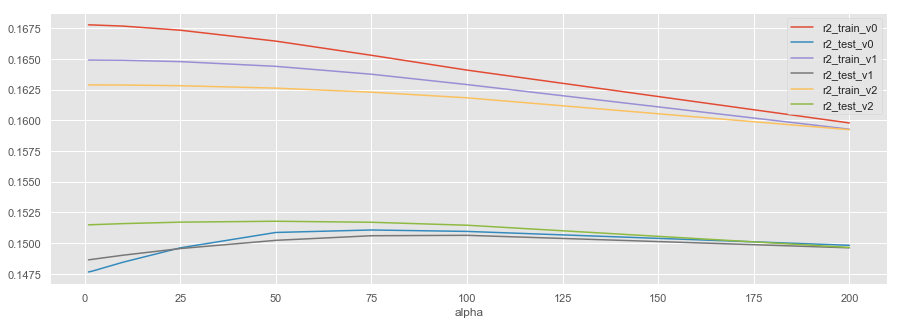

In [99]:
df_lasso_r2.groupby('alpha').mean().plot(figsize=(15,5))

__Fazit:__  
Ja, wir konnten manuell ein __besseres Ergebnis als mit LassoCV__  erreichen. Der Wert für alpha liegt dafür bei ```100```.
Die R-squared-Werte von Trainigs- und Testdaten lassen sich nur bedingt mit denen, die für einen ganzen Datenbestand ermittelt wurden vergleichen. Trotzdem sehen wir, dass wir in etwa mit der Baseline gleichauf sind.

__Koeffizienten:__  
Im Folgenden werden die Koeffizienten für die drei Modelle ausgegeben:

In [100]:
for key in coef_dict:
    print(key+"\n")
    print(coef_dict[key][coef_dict[key] != 0])
    print("*"*100+"\n")

v0

Monthly_Premium_Auto             2.607498e+03
Months_Since_Policy_Inception    6.962233e+00
Number_of_Open_Complaints       -1.652070e+02
Number_of_Policies               8.019136e+01
State_Washington                 3.559648e+00
Education_HighSchoolorBelow      1.403148e+02
Employment_Status_Employed       1.498812e+02
Gender_F                         3.766025e+00
Gender_M                        -1.104477e-13
Location_Code_Suburban          -3.622853e+01
Marital_Status_Divorced          7.200180e+01
Marital_Status_Single           -8.289692e+01
Policy_Type_SpecialAuto          4.957507e+01
Policy_CorporateL1               2.674937e+01
Policy_CorporateL2              -9.842222e+01
Policy_CorporateL3              -3.253013e+01
Vehicle_Class_Four_DoorCar      -8.772106e+01
Vehicle_Class_SUV                1.219441e+02
Vehicle_Class_SportsCar          5.678135e+00
Vehicle_Size_Small               1.733912e+01
Vehicle_Size_Large              -1.362418e+01
dtype: float64
***************

__Fazit:__  
Die __offenen Beschwerden__ gehen auch hier negativ ein.  
Mit der __Police Corporate L2__ scheinen wir generell Geld zu verlieren.  
Eine steigende __Anzal an Policen__ erhöht den Kundenwert.

### Automatisierte Feature-Selection

Bis jetzt haben wir ja mit der Feature-Liste der jeweiligen Modellierung mit OLS gearbeitet.  
Hilft es, wenn wir für Lasso eine eigene, automatisierte Feature-Selection durchführen?

In [101]:
df_lasso_v0 = df_reg_v0.select_dtypes(np.number)

In [102]:
X = np.array(df_lasso_v0.iloc[:,1:])
y = np.array(df_lasso_v0.iloc[:,0])

In [103]:
clf = LassoCV(cv=5, n_alphas=100, normalize=True, n_jobs=-1, random_state=1)

Dazu nutzen wir ```SelectFromModel```:

In [104]:
sfm = SelectFromModel(clf, threshold='mean')
sfm.fit(X, y)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=-1, normalize=True, positive=False,
    precompute='auto', random_state=1, selection='cyclic', tol=0.0001,
    verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold='mean')

__Fazit:__  
Wir erreichen hier ein R-squared von ```0.16```, was sich weiterhin im Bereich der anderen Modelle bewegt.

In [105]:
sfm.estimator_.score(X,y)

0.1595371477739237

Folgende Features sollen wir laut der Feature-Selection nutzen:

In [106]:
df_lasso_v0.columns[1:][sfm.get_support()]

Index(['Monthly_Premium_Auto', 'Number_of_Open_Complaints',
       'Number_of_Policies', 'Employment_Status_Employed',
       'Marital_Status_Single', 'Policy_CorporateL2',
       'Vehicle_Class_Four_DoorCar', 'Vehicle_Class_SUV',
       'Vehicle_Class_SportsCar'],
      dtype='object')

Für die genannten Features lassen wir uns die Koeffizienten ausgeben:

In [107]:
df_coeffs = pd.DataFrame({'feature': df_lasso_v0.columns[1:], 'coeffs': sfm.estimator_.coef_})

In [108]:
df_coeffs[df_coeffs.coeffs!=0]

,feature,coeffs
1,Monthly_Premium_Auto,73.807521
4,Number_of_Open_Complaints,-88.704112
5,Number_of_Policies,18.974971
21,Employment_Status_Employed,276.865108
24,Employment_Status_Unemployed,-4.664934
32,Marital_Status_Single,-62.718210
37,Policy_CorporateL2,-20.455296
45,Vehicle_Class_Four_DoorCar,-67.748731
48,Vehicle_Class_SUV,186.927330
49,Vehicle_Class_SportsCar,67.101729


Die Werte gleichen sich größtenteils mit den schon bekannten Werten. 
Interessant ist allerdings der Intercept, der für "unbeleckte" Kunden einen Wert von ```943 $``` veranschlagt:

In [109]:
sfm.estimator_.intercept_

943.1741522103875

#### Fazit für Lasso

Wir konnten unsere Ergebnisse auch mit der Nutzung von Lasso nicht wirklich verbessern.  
Daher prüfen wir im Folgenden die diagnstischen Plots, ob diese uns eine Erklärung geben können

### Betrachtung der übrigen Plots

Nachdem wir uns bereits den Residuals-vs-Leverage-Plot angeschaut haben, folgen jetzt die weiteren drei bekannten Plots.

#### Residuals-vs-Fitted-Plot

--------------------------------------------------
Residuals vs. Fitted


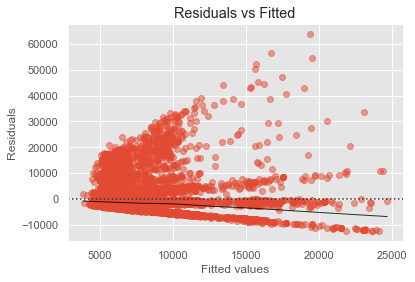

In [110]:
plot_diagnostic_plots(ols_m_fe_v1, df=df_reg_v1, dependent_variable='Customer_Lifetime_Value', res_fit=True)

__Spannend:__  
+ Die schwarze Linie ist generell unterhalb der x-Achse - was bedeutet, dass wir immer überschätzen... Schade.
+ Die Werte streuen weiter nach rechts stärker, das bedeutet: je höher der CLV ist, desto schlechter können wir schätzen.

__Folge:__  
+ Wir sollten uns anschauen, ob sich die Ergebnisse verbessern lassen, wenn wir mehr als nur die 20 gröbsten Ausreißer entfernen. Eventuell sollten wir das komplette vierte Quartil für den nächsten Versuch ignorieren.

#### Q-Q-Plot

--------------------------------------------------
Q-Q-Plot


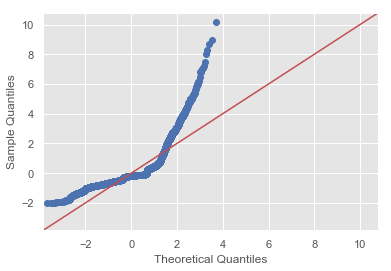

In [111]:
plot_diagnostic_plots(ols_m_fe_v1, qq=True)

__Wir sehen:__  
Wir haben wohl keine Normalverteilung, daher lassen sich die uns zur Verfügung stehenden Werkzeuge nur mit Einschränkungen verwenden.  

__Folge:__  
Fraglich ist, ob wir durch eine kleinteiligere Untersuchung des Datenbestandes hier eine "normalere" Verteilung innerhalb der Subgruppen vorfinden. Wir werden das prüfen.

#### Scale-Location-Plot

--------------------------------------------------
Scale-Location


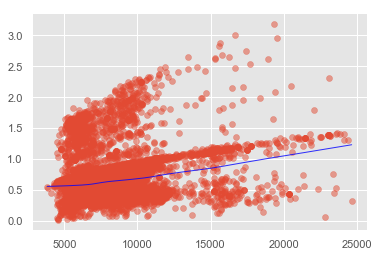

In [112]:
plot_diagnostic_plots(ols_m_fe_v1, scale_loc=True)

__Wir sehen:__  
An der Steigung der blauen Linie sehen wir, dass die Streuung der Residuen nach rechts zunimmt.  
Daher müssen wir davon ausgehen, dass die Varianz über den Datenbestand nicht gleichverteilt ist (Heteroskedastizität).

__Folge:__  
Wir vermuten, dass wir für die unteren zwei Quartile ein verbessertes Ergebnis erzielen können, wenn wir nur mit diesen Daten rechnen.  
Ob diese Vermutung auch für die oberen zwei Quartile zutrifft, müssen Experimente zeigen.

### Modellierung nach Split in Quartile

Nachdem die Plots uns gezeigt haben, dass wir die Kunden eventuell in einzelnen Batches betrachten sollten, teilen wir diese in die vier Quartile auf:

In [113]:
quartil_1 = df.Customer_Lifetime_Value.quantile(q=0.25)
quartil_2 = df.Customer_Lifetime_Value.quantile(q=0.5)
quartil_3 = df.Customer_Lifetime_Value.quantile(q=0.75)

In [114]:
df_q_1 = df_ohe[df_ohe.Customer_Lifetime_Value <= quartil_1]
df_q_2 = df_ohe[(df_ohe.Customer_Lifetime_Value > quartil_1) & (df_ohe.Customer_Lifetime_Value <= quartil_2)]
df_q_3 = df_ohe[(df_ohe.Customer_Lifetime_Value > quartil_2) & (df_ohe.Customer_Lifetime_Value <= quartil_3)]
df_q_4 = df_ohe[df_ohe.Customer_Lifetime_Value > quartil_3]

#### Helper-Funktion
Zur Vereinfachung lassen wir uns die Qualitätsmaßzahlen, die Koeffizienten und die vier diagnostischen Plots dirket über eine Funktion ausgeben, wobei das erstellte Modell zurückgegeben wird.

In [115]:
def get_model_results(df, formula):
    ols_df = smf.ols(formula=formula, data=df).fit()
    print("adjusted R-squared:\t\t{}".format(round(ols_df.rsquared_adj,2)))
    print("F-Statistic:\t\t\t{}".format(round(ols_df.fvalue,2)))
    print("p-Value für F-Statistic:\t{}".format(round(ols_df.f_pvalue,2)))
    print("Mean Squared Error:\t\t{}".format(round(ols_df.mse_resid,2)))
    print("AIC:\t\t\t\t{}".format(round(ols_df.aic,2)))
    print("BIC:\t\t\t\t{}".format(round(ols_df.bic,2)))
    print("-"*30)
    print('Koeffizienten:')
    df_res = pd.DataFrame([ols_df.params, ols_df.pvalues], index=['coefficient', 'p_value']).transpose()
    display(df_res[df_res.p_value <= 0.05])
    plot_diagnostic_plots(ols_df, df=df, dependent_variable='Customer_Lifetime_Value', res_lev=True, res_fit=True, qq=True, scale_loc=True)
    return ols_df

#### Ergebnisse für Quartil 1

adjusted R-squared:		0.98
F-Statistic:			2513.38
p-Value für F-Statistic:	0.0
Mean Squared Error:		5739.14
AIC:				26289.52
BIC:				26518.87
------------------------------
Koeffizienten:


/Users/DE2303318/miniconda3/envs/statistics/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/DE2303318/miniconda3/envs/statistics/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/DE2303318/miniconda3/envs/statistics/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/DE2303318/miniconda3/envs/statistics/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,coefficient,p_value
Intercept,-104.890829,5.234857e-33
Income,0.001030,4.618297e-27
Monthly_Premium_Auto,38.304471,0.000000e+00
Number_of_Open_Complaints,-58.140590,9.347424e-216
Number_of_Policies,327.961707,3.461313e-300
Total_Claim_Amount,-0.122148,4.383747e-15
State_Arizona,-21.750625,8.749014e-09
State_California,-18.552373,2.093819e-08
State_Nevada,-23.700152,4.282978e-07
State_Oregon,-20.194134,3.635412e-09


--------------------------------------------------
Residuals vs. Leverage


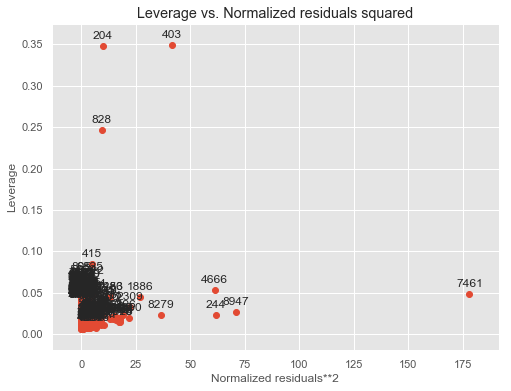

--------------------------------------------------
Residuals vs. Fitted


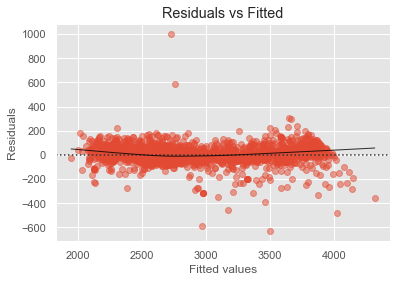

--------------------------------------------------
Q-Q-Plot


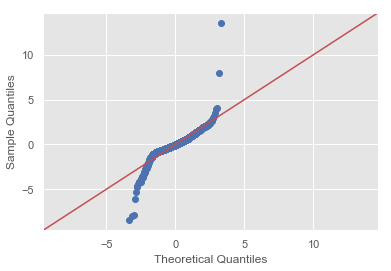

--------------------------------------------------
Scale-Location


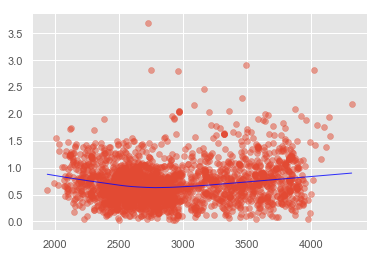

In [116]:
ols_q1 = get_model_results(df_q_1, formula_v0)

__Fazit:__  
Die Plots sehen plötzlich sehr viel besser aus. Wir haben zwar weiterhin Ausreißer, allerdings längst nicht so schlimm.  
Und das Beste: wir konnten ein R-squared von ```0.98``` und einen MSE von ```5739.14``` erreichen, der Wert der F-Statistik ist massiv gestiegen, AIC und BIC stark gefallen.  
Zumindest für das unterste Quartil haben wir ein __bombastisches Ergebnis__.

Für die spätere Nachmodellierung schreiben wir uns die Patsy-Formel auf:

In [117]:
get_attributes_because_patsy_sucks(ols_q1.pvalues[ols_q1.pvalues<=0.05].index.tolist(), comma=False)

' + Intercept + Income + Monthly_Premium_Auto + Number_of_Open_Complaints + Number_of_Policies + Total_Claim_Amount + State_Arizona + State_California + State_Nevada + State_Oregon + State_Washington + Coverage_Basic + Coverage_Extended + Coverage_Premium + Education_HighSchoolorBelow + Education_College + Education_Bachelor + Employment_Status_Employed + Employment_Status_MedicalLeave + Employment_Status_Retired + Employment_Status_Unemployed + Gender_F + Gender_M + Location_Code_Rural + Location_Code_Suburban + Location_Code_Urban + Marital_Status_Divorced + Marital_Status_Married + Marital_Status_Single + Policy_Type_CorporateAuto + Policy_Type_PersonalAuto + Policy_Type_SpecialAuto + Policy_CorporateL1 + Policy_PersonalL1 + Policy_PersonalL2 + Policy_PersonalL3 + Policy_SpecialL3 + Vehicle_Class_SUV + Vehicle_Class_SportsCar + Vehicle_Size_Small + Vehicle_Size_Medsize + Vehicle_Size_Large'

In [118]:
formula_q1 = 'Customer_Lifetime_Value ~ Income + Monthly_Premium_Auto + Number_of_Open_Complaints + Number_of_Policies + Total_Claim_Amount + State_Arizona + State_California + State_Nevada + State_Oregon + State_Washington + Coverage_Basic + Coverage_Extended + Coverage_Premium + Education_HighSchoolorBelow + Education_College + Education_Bachelor + Employment_Status_Employed + Employment_Status_MedicalLeave + Employment_Status_Retired + Employment_Status_Unemployed + Gender_F + Gender_M + Location_Code_Rural + Location_Code_Suburban + Location_Code_Urban + Marital_Status_Divorced + Marital_Status_Married + Marital_Status_Single + Policy_Type_CorporateAuto + Policy_Type_PersonalAuto + Policy_Type_SpecialAuto + Policy_CorporateL1 + Policy_PersonalL1 + Policy_PersonalL2 + Policy_PersonalL3 + Policy_SpecialL3 + Vehicle_Class_SUV + Vehicle_Class_SportsCar + Vehicle_Size_Small + Vehicle_Size_Medsize + Vehicle_Size_Large'

#### Ergebnisse für Quartil 2

adjusted R-squared:		0.62
F-Statistic:			95.75
p-Value für F-Statistic:	0.0
Mean Squared Error:		87959.16
AIC:				32523.85
BIC:				32753.19
------------------------------
Koeffizienten:


,coefficient,p_value
Income,0.002090,1.287625e-08
Monthly_Premium_Auto,39.352917,6.097789e-153
Number_of_Open_Complaints,-58.842205,2.947426e-18
Number_of_Policies,37.619323,4.289198e-27
Total_Claim_Amount,0.260856,1.537364e-06
Coverage_Basic,802.650859,4.165150e-274
Coverage_Extended,621.253146,1.198359e-206
Coverage_Premium,-1403.589541,2.444808e-165
Education_HighSchoolorBelow,36.349530,1.250657e-02
Education_Master,57.346643,4.660678e-03


--------------------------------------------------
Residuals vs. Leverage


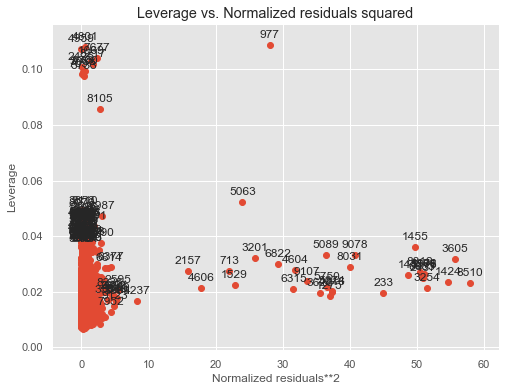

--------------------------------------------------
Residuals vs. Fitted


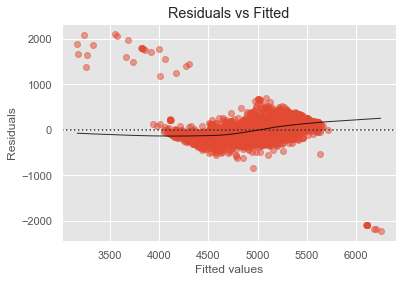

--------------------------------------------------
Q-Q-Plot


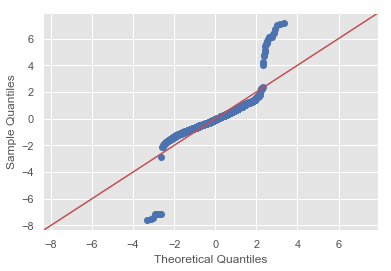

--------------------------------------------------
Scale-Location


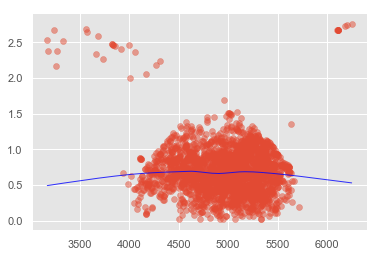

In [119]:
ols_q2 = get_model_results(df_q_2, formula_v0)

__Fazit:__  
Hier sinkt R-squared im Vergleich zum Quartil_1 wieder, ist mit ```0.62``` aber immernoch weit über den bisherigen Ergebnissen.  
Auch der MSE ist gestiegen, AIC und BIC ebenso.

In [120]:
get_attributes_because_patsy_sucks(ols_q2.pvalues[ols_q2.pvalues<=0.05].index.tolist(), comma=False)

' + Income + Monthly_Premium_Auto + Number_of_Open_Complaints + Number_of_Policies + Total_Claim_Amount + Coverage_Basic + Coverage_Extended + Coverage_Premium + Education_HighSchoolorBelow + Education_Master + Employment_Status_Employed + Employment_Status_Retired + Employment_Status_Unemployed + Location_Code_Rural + Location_Code_Suburban + Marital_Status_Married + Marital_Status_Single + Policy_CorporateL2 + Policy_SpecialL1 + Vehicle_Class_Four_DoorCar + Vehicle_Class_SUV + Vehicle_Class_SportsCar + Vehicle_Class_Two_DoorCar'

In [121]:
formula_q2 = 'Customer_Lifetime_Value ~ Income + Monthly_Premium_Auto + Number_of_Open_Complaints + Number_of_Policies + Total_Claim_Amount + Coverage_Basic + Coverage_Extended + Coverage_Premium + Education_HighSchoolorBelow + Education_Master + Employment_Status_Employed + Employment_Status_Retired + Employment_Status_Unemployed + Location_Code_Rural + Location_Code_Suburban + Marital_Status_Married + Marital_Status_Single + Policy_CorporateL2 + Policy_SpecialL1 + Vehicle_Class_Four_DoorCar + Vehicle_Class_SUV + Vehicle_Class_SportsCar + Vehicle_Class_Two_DoorCar'

#### Ergebnisse für Quartil 3

adjusted R-squared:		0.27
F-Statistic:			21.62
p-Value für F-Statistic:	0.0
Mean Squared Error:		604973.42
AIC:				36897.77
BIC:				37138.55
------------------------------
Koeffizienten:


,coefficient,p_value
Intercept,1563.506775,5.869794e-62
Monthly_Premium_Auto,9.206620,3.262280e-04
Number_of_Policies,-30.566773,7.756824e-05
State_Arizona,274.829383,4.327401e-12
State_California,312.727947,9.974178e-20
State_Nevada,304.912447,1.021788e-09
State_Oregon,319.875117,8.230033e-19
State_Washington,351.161881,2.520159e-10
Coverage_Basic,818.168351,2.526865e-101
Coverage_Extended,171.656718,1.531267e-05


--------------------------------------------------
Residuals vs. Leverage


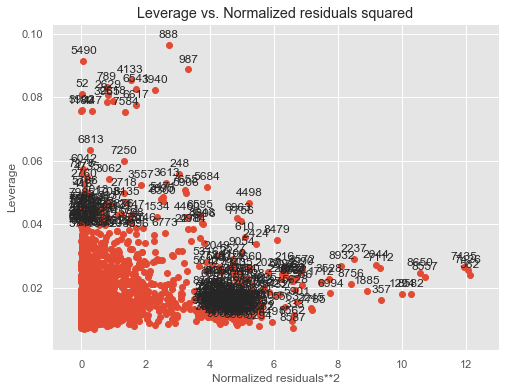

--------------------------------------------------
Residuals vs. Fitted


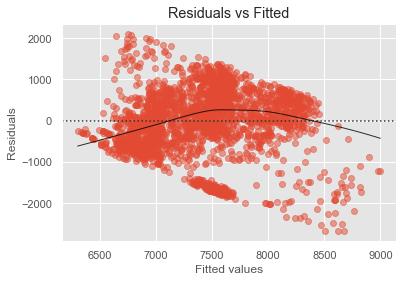

--------------------------------------------------
Q-Q-Plot


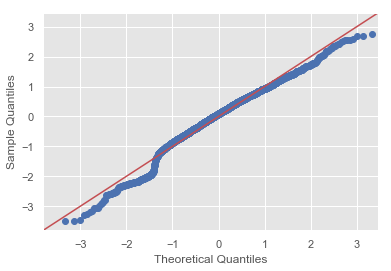

--------------------------------------------------
Scale-Location


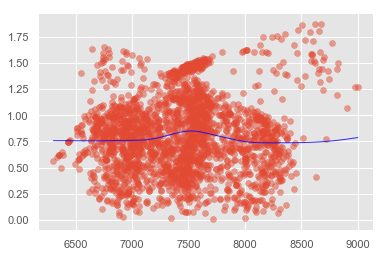

In [122]:
ols_q3 = get_model_results(df_q_3, formula_v0)

__Fazit:__  
Auch hier sinkt R-squared weiter auf ```0.27```, was trotzdem noch 10 Prozentpunkte über der Baseline liegt.  
Ähnliches Verhalten ist bei den anderen Gütemaßzahlen zu beobachten.

In [123]:
get_attributes_because_patsy_sucks(ols_q3.pvalues[ols_q3.pvalues<=0.05].index.tolist(), comma=False)

' + Intercept + Monthly_Premium_Auto + Number_of_Policies + State_Arizona + State_California + State_Nevada + State_Oregon + State_Washington + Coverage_Basic + Coverage_Extended + Coverage_Premium + Education_HighSchoolorBelow + Education_College + Education_Bachelor + Education_Master + Education_Doctor + Employment_Status_Disabled + Employment_Status_Employed + Employment_Status_MedicalLeave + Employment_Status_Unemployed + Gender_F + Gender_M + Location_Code_Rural + Location_Code_Suburban + Location_Code_Urban + Marital_Status_Divorced + Marital_Status_Married + Marital_Status_Single + Policy_Type_CorporateAuto + Policy_Type_PersonalAuto + Policy_Type_SpecialAuto + Policy_CorporateL1 + Policy_CorporateL2 + Policy_CorporateL3 + Policy_PersonalL1 + Policy_PersonalL2 + Policy_PersonalL3 + Policy_SpecialL1 + Vehicle_Class_Four_DoorCar + Vehicle_Class_LuxuryCar + Vehicle_Class_SUV + Vehicle_Class_SportsCar + Vehicle_Class_Two_DoorCar + Vehicle_Size_Small + Vehicle_Size_Medsize + Vehicle

In [124]:
formula_q3 = 'Customer_Lifetime_Value ~ Monthly_Premium_Auto + Number_of_Policies + State_Arizona + State_California + State_Nevada + State_Oregon + State_Washington + Coverage_Basic + Coverage_Extended + Coverage_Premium + Education_HighSchoolorBelow + Education_College + Education_Bachelor + Education_Master + Education_Doctor + Employment_Status_Disabled + Employment_Status_Employed + Employment_Status_MedicalLeave + Employment_Status_Unemployed + Gender_F + Gender_M + Location_Code_Rural + Location_Code_Suburban + Location_Code_Urban + Marital_Status_Divorced + Marital_Status_Married + Marital_Status_Single + Policy_Type_CorporateAuto + Policy_Type_PersonalAuto + Policy_Type_SpecialAuto + Policy_CorporateL1 + Policy_CorporateL2 + Policy_CorporateL3 + Policy_PersonalL1 + Policy_PersonalL2 + Policy_PersonalL3 + Policy_SpecialL1 + Vehicle_Class_Four_DoorCar + Vehicle_Class_LuxuryCar + Vehicle_Class_SUV + Vehicle_Class_SportsCar + Vehicle_Class_Two_DoorCar + Vehicle_Size_Small + Vehicle_Size_Medsize + Vehicle_Size_Large'

#### Ergebnisse für Quartil 4

adjusted R-squared:		0.13
F-Statistic:			9.69
p-Value für F-Statistic:	0.0
Mean Squared Error:		65637336.22
AIC:				47634.53
BIC:				47875.35
------------------------------
Koeffizienten:


,coefficient,p_value
Intercept,4606.671363,1.092850e-09
Number_of_Policies,-1657.021336,1.034314e-57
State_Arizona,857.968360,2.982428e-02
State_Nevada,1122.990082,2.484748e-02
State_Washington,1488.505812,4.228953e-03
Coverage_Basic,2361.439731,1.639085e-11
Coverage_Extended,1119.080894,2.800467e-04
Education_HighSchoolorBelow,1151.625508,1.703745e-03
Education_Bachelor,894.859982,1.805145e-02
Education_Master,1488.172075,5.071764e-03


--------------------------------------------------
Residuals vs. Leverage


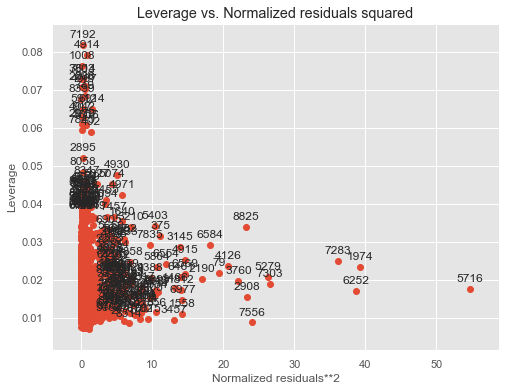

--------------------------------------------------
Residuals vs. Fitted


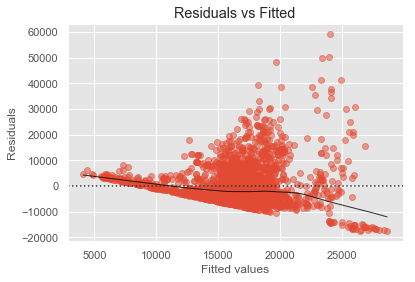

--------------------------------------------------
Q-Q-Plot


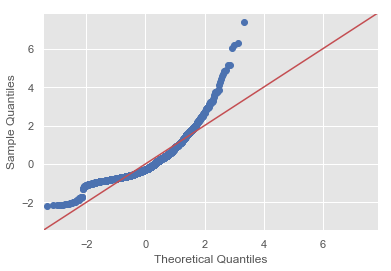

--------------------------------------------------
Scale-Location


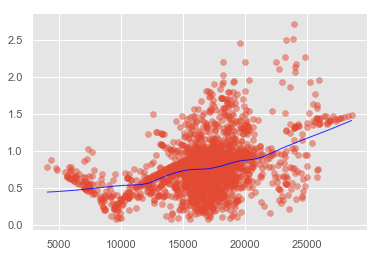

In [125]:
ols_q4 = get_model_results(df_q_4, formula_v0)

__Fazit:__  
Hier sind wir in allen Bereichen wieder auf dem Niveau der Baseline - allerdings auch nicht massiv schlechter.

In [126]:
get_attributes_because_patsy_sucks(ols_q4.pvalues[ols_q4.pvalues<=0.05].index.tolist(), comma=False)

' + Intercept + Number_of_Policies + State_Arizona + State_Nevada + State_Washington + Coverage_Basic + Coverage_Extended + Education_HighSchoolorBelow + Education_Bachelor + Education_Master + Employment_Status_Employed + Employment_Status_Unemployed + Gender_F + Gender_M + Location_Code_Rural + Location_Code_Suburban + Location_Code_Urban + Marital_Status_Divorced + Marital_Status_Married + Marital_Status_Single + Policy_Type_CorporateAuto + Policy_Type_PersonalAuto + Policy_Type_SpecialAuto + Policy_PersonalL1 + Vehicle_Class_LuxurySUV + Vehicle_Size_Small + Vehicle_Size_Medsize + Vehicle_Size_Large'

In [127]:
formula_q4 = 'Customer_Lifetime_Value ~ Number_of_Policies + State_Arizona + State_Nevada + State_Washington + Coverage_Basic + Coverage_Extended + Education_HighSchoolorBelow + Education_Bachelor + Education_Master + Employment_Status_Employed + Employment_Status_Unemployed + Gender_F + Gender_M + Location_Code_Rural + Location_Code_Suburban + Location_Code_Urban + Marital_Status_Divorced + Marital_Status_Married + Marital_Status_Single + Policy_Type_CorporateAuto + Policy_Type_PersonalAuto + Policy_Type_SpecialAuto + Policy_PersonalL1 + Vehicle_Class_LuxurySUV + Vehicle_Size_Small + Vehicle_Size_Medsize + Vehicle_Size_Large'

#### Bewertung des Splits in Quartile

Generell finden wir den Ansatz __sehr gelungen__, vor allem, wenn man sich die __Ergebnisse von den unteren beiden Quartilen__ anschaut.

Einen Wermutstropfen gibt es allerdings: man muss bedenken, dass man normalerweise hier noch keine Segmentierung vorliegen hat, da ja der ```Customer_Lifetime_Value``` eben noch nicht bekannt ist.

Wenn wir den obigen Ansatz weiter verfolgen wollen, müssen wir also noch eine Klassifikation in die Kundenklassen ```A, B, C, D``` vornehmen. Daran versuchen wir uns im nächsten Kapitel.

## Klassifikation: Kundengruppen

Für die Klassifikation müssen wir uns eine neue Zielvariable ```Customer_Class``` erstellen.  
Wenn wir diese gut vorhersagen können, kommen wir unserem Ziel ein Stück näher.

### Hinzufügen der Klassen zum Datenbestand

In [129]:
df_class = df.copy()

quartil_1_class = df_class.Customer_Lifetime_Value.quantile(q=0.25)
quartil_2_class = df_class.Customer_Lifetime_Value.quantile(q=0.5)
quartil_3_class = df_class.Customer_Lifetime_Value.quantile(q=0.75)

In [130]:
def get_customer_class(clv):
    if clv <= quartil_1_class:
        return 'D'
    elif (clv > quartil_1_class) & (clv <= quartil_2_class):
        return 'C'
    elif (clv > quartil_2_class) & (clv <= quartil_3_class):
        return 'B'
    else:
        return 'A'

In [131]:
df_class['Customer_Class'] = df_class.apply(lambda row: get_customer_class(row.Customer_Lifetime_Value), axis=1)
df_class.Customer_Class = pd.Categorical(df_class.Customer_Class)

In [132]:
df_class = df_class.drop(columns=['Customer_Lifetime_Value', 'Response', 'Renew_Offer_Type', 'Sales_Channel', 'Effective_To_Date'])
df_class.head()

,Customer_ID,State,Coverage,Education,Employment_Status,Gender,Income,Location_Code,Marital_Status,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Policy_Type,Policy,Total_Claim_Amount,Vehicle_Class,Vehicle_Size,Customer_Class
0,BU79786,Washington,Basic,Bachelor,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,384.811157,Two-Door Car,Medsize,D
1,QZ44356,Arizona,Extended,Bachelor,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,1131.464966,Four-Door Car,Medsize,B
2,AI49188,Nevada,Premium,Bachelor,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,566.472229,Two-Door Car,Medsize,A
3,WW63253,California,Basic,Bachelor,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,529.881348,SUV,Medsize,B
4,HB64268,Washington,Basic,Bachelor,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,138.130875,Four-Door Car,Medsize,D


Wie bei der Regression haben wir wieder die nicht relevanten Attribute entfernt, zudem haben wir auf Basis der Quartile die Zielvariable ```Customer_Class```angelegt.

### Bivariate Betrachtung der neuen Zielvariablen

Nachdem die neue abhängige Variable bei der bivariaten Betrachtung noch nicht vorhanden war, wird diese hier nachgeholt:

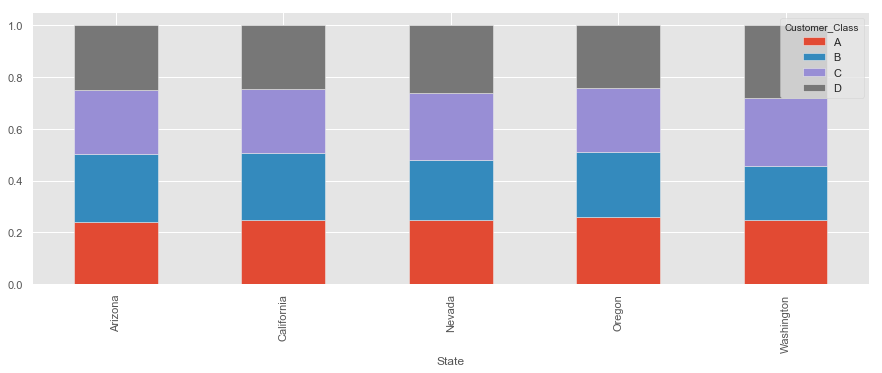

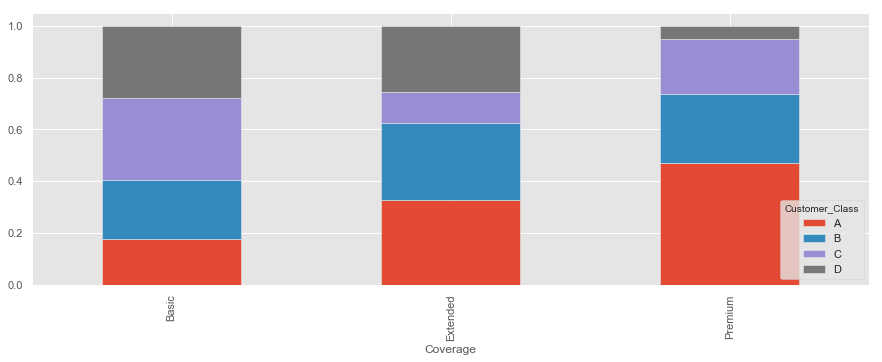

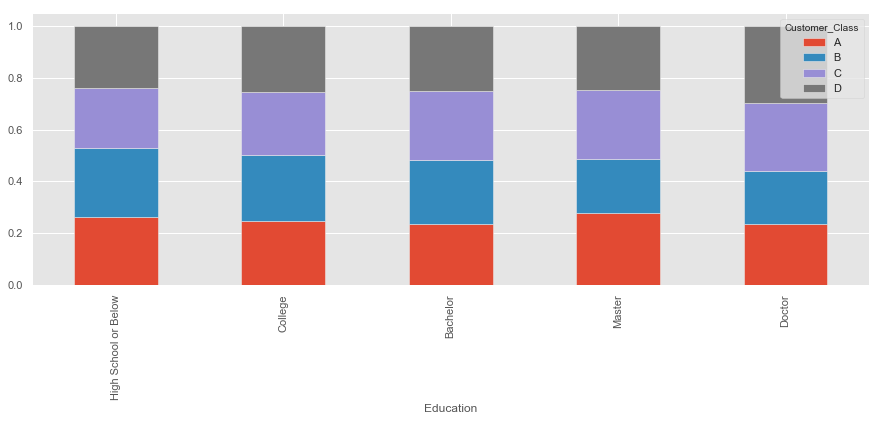

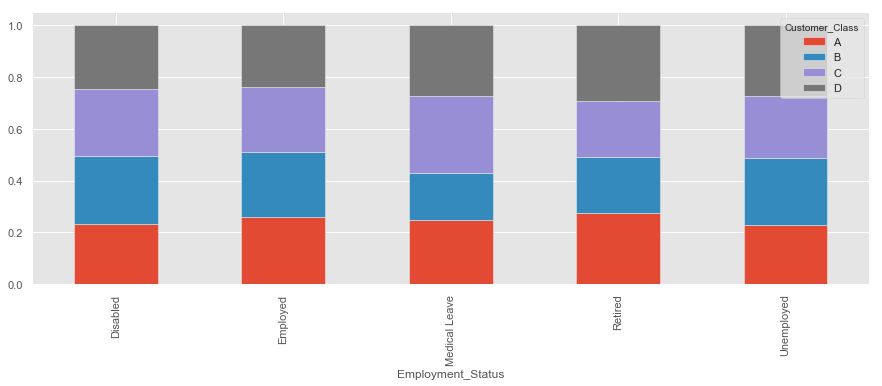

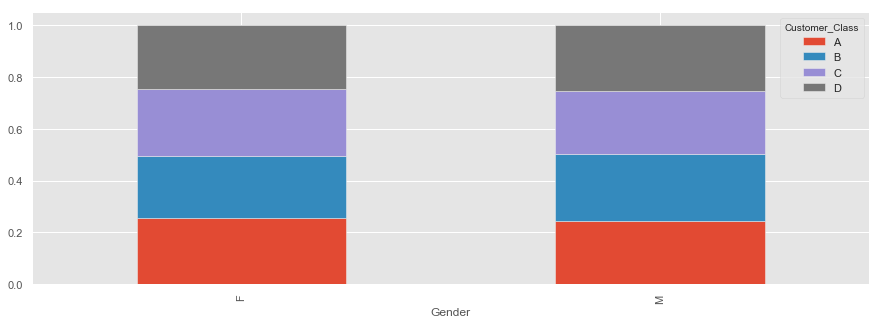

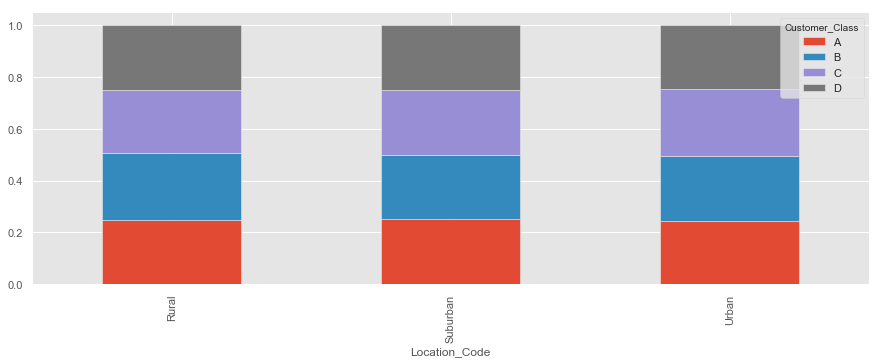

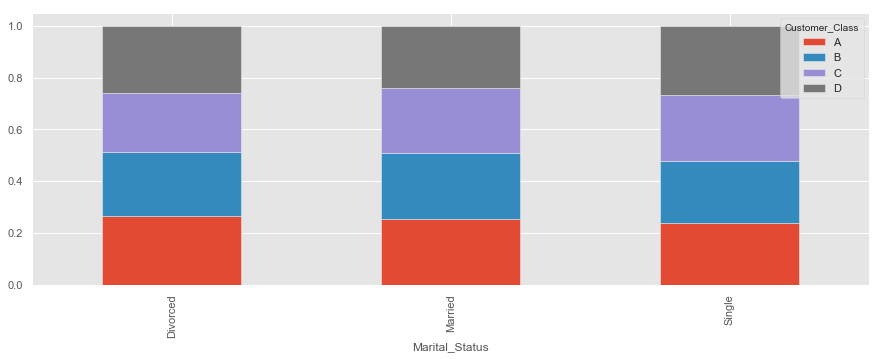

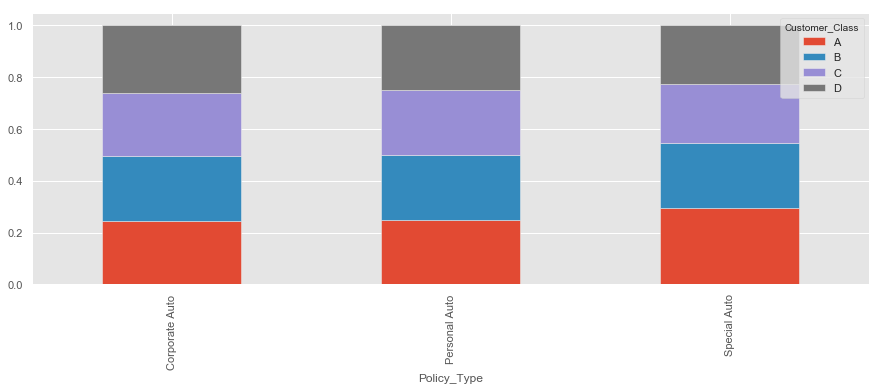

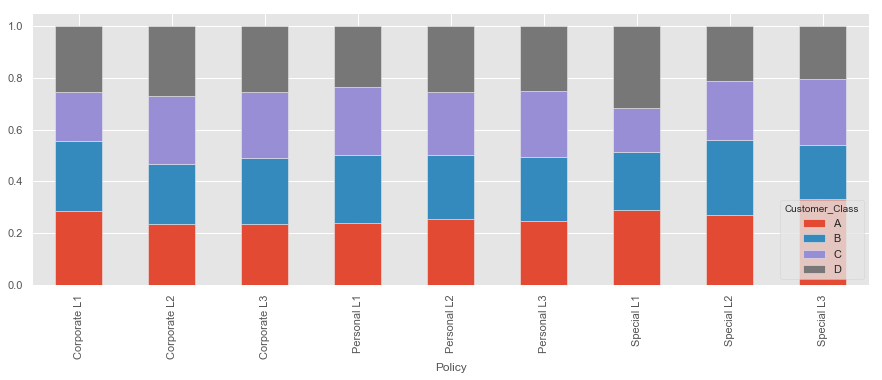

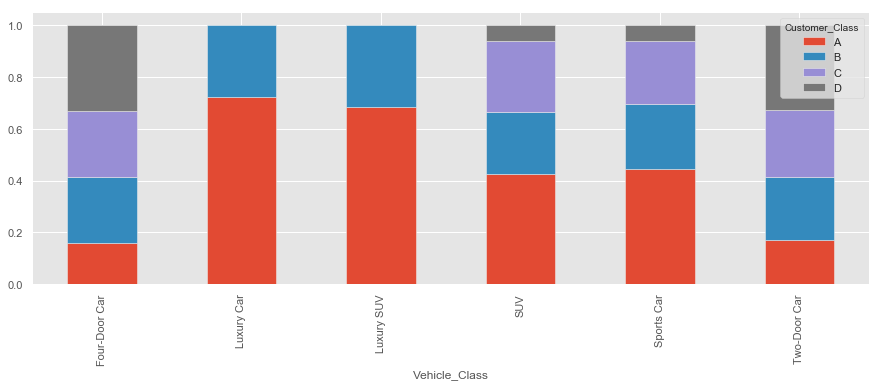

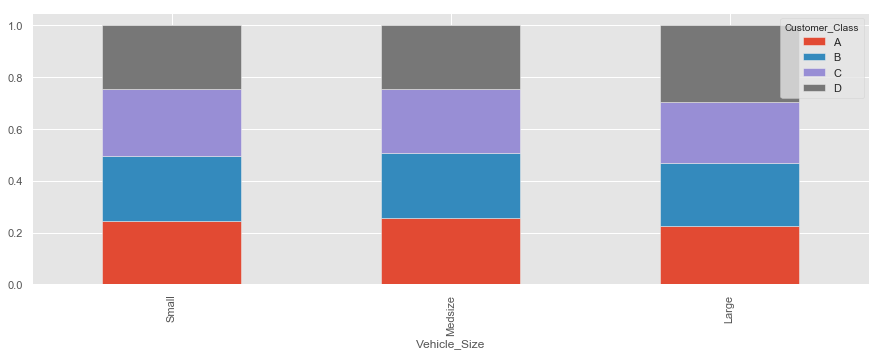

In [132]:
plot_bivariate_categorical('Customer_Class', df_class)

Diese Ergebnisse machen uns __keine große Hoffnung:__ mit Ausnahme der ```Vehicle_Class``` (Gruppen ```B``` und ```C``` fahren wohl keine Luxusautos) scheinen die Unterschiede vernachlässigbar.  
Nachdem wir allerding nicht nur kategoriale Daten zur Verfügung haben, geben wir uns nicht geschlagen.

__Anmerkung:__  Eine univariate Betrachtung ergibt nicht viel Sinn, da die Klassen auf den Quartilen des Datenbestandes basieren.

### Klassifikation über logistische Regression

Wir nutzen Logit für die logistische Regression und müssen multinominal arbeiten, da die Zielvariable nicht binär vorliegt:

In [133]:
X = df_class.drop(columns=['Customer_ID','Customer_Class']).assign(Intercept=1)
X = pd.get_dummies(X)
y = df_class.Customer_Class

Zu den X-Werten muss hier zusätzlich noch ein Intercept hinzugefügt werden, da Statsmodels dies nicht automatisch durchführt. Außerdem benötigen wie wieder ein One-Hot-Encoding, da mit dem Ursprungsdatensatz gearbeitet wird.

In [134]:
logreg = MNLogit(y, X).fit(maxiter=100)
logreg.summary().as_text

         Current function value: 0.773744
         Iterations: 100


/Users/DE2303318/miniconda3/envs/statistics/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/DE2303318/miniconda3/envs/statistics/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:3967: RuntimeWarning: invalid value encountered in sqrt
  bse = np.sqrt(np.diag(self.cov_params()))


<bound method Summary.as_text of <class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
Dep. Variable:         Customer_Class   No. Observations:                 9134
Model:                        MNLogit   Df Residuals:                     9008
Method:                           MLE   Df Model:                          123
Date:                Wed, 12 Dec 2018   Pseudo R-squ.:                  0.4419
Time:                        02:02:31   Log-Likelihood:                -7067.4
converged:                      False   LL-Null:                       -12662.
                                        LLR p-value:                     0.000
               Customer_Class=B       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Income                           2.583e-06   1.84e-06      1.402      0.161   -1.03e-06

Die Maximale Anzahl an Iterationen haben wir auf ```100``` gesetzt, da bei der Größe dieses Datensatzes der Standardwert nicht ausreicht, um vollständig zu optimieren. Bei dem von uns gewählten Wert läuft das Modell zwar auch nicht ohne Abbruch durch, aber der ```Function Value``` ist der selbe wie bei z.B. ```5000```.

In der Ergebniszusammenfassung sehen wir, dass sehr viele Attribute für die Klassifikation nicht ausschlaggebend sind, da sie einen ```p-value``` $>0.05$ haben. Daher lassen wir uns im folgenden nur jene anzeigen, welche einen ```p-value``` $<=0.05$ haben.

In [135]:
df_class_coef = pd.DataFrame([logreg.params[0], logreg.pvalues[0], logreg.params[1], logreg.pvalues[1], logreg.params[2], logreg.pvalues[2]], index=['coefficient_B', 'p_value_B', 'coefficient_C', 'p_value_C', 'coefficient_D', 'p_value_D']).transpose()
df_class_coef[(df_class_coef.p_value_B <= 0.05) | (df_class_coef.p_value_C <=0.05) | (df_class_coef.p_value_D <= 0.05)]

,coefficient_B,p_value_B,coefficient_C,p_value_C,coefficient_D,p_value_D
Monthly_Premium_Auto,-0.023076,6.907487e-07,-0.031454,1.518346e-08,-0.246832,2.872613e-30
Number_of_Open_Complaints,0.136072,2.548298e-04,0.138347,3.734668e-04,0.596248,1.235564e-08
Number_of_Policies,0.206909,8.847741e-49,0.161349,4.114830e-27,-13.153637,1.678870e-109
Total_Claim_Amount,0.000028,8.930391e-01,-0.000198,4.382879e-01,0.001519,2.233335e-02


Interessant hieran ist, dass für jedes Quartil, die selben Attribute zur Klassifikation wichtig sind. Ebenfalls zu erwähnen ist, dass z.B. die ```Number_of_Open_Complaints``` und die ```Number_of_Policies``` genau wie bei der vorherigen Regression statistisch Signifikant sind sowie hier auch die bedeutendsten Elemente in Bezug auf die Koeffizienten darstellen.  
Eine weitere Auffälligkeit ist, dass in der Kategerie D die ```Number_of_Policies``` eine negative Auswirkung haben.

#### Update Model

Mit den neuen Erkenntnissen aktualisieren wir unser vorheriges Modell.

In [136]:
logreg_final_features = ['Intercept', 'Monthly_Premium_Auto', 'Number_of_Open_Complaints', 'Number_of_Policies', 
                         'Total_Claim_Amount']

In [137]:
X = X[logreg_final_features]
logreg_updated = MNLogit(y, X).fit()
logreg_updated.summary()

Optimization terminated successfully.
         Current function value: 0.815264
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:         Customer_Class   No. Observations:                 9134
Model:                        MNLogit   Df Residuals:                     9119
Method:                           MLE   Df Model:                           12
Date:                Wed, 12 Dec 2018   Pseudo R-squ.:                  0.4119
Time:                        02:02:32   Log-Likelihood:                -7446.6
converged:                       True   LL-Null:                       -12662.
                                        LLR p-value:                     0.000
=============================================================================================
         Customer_Class=B       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.6688      0.112      5.989      0.000       0.450       0.888
Monthly_Premium_Auto         -0.0145      0.001    -12.739      0.000      -0.017      -0.012
Number_of_Open_Complaints     0.1388      0.037      3.768      0.000       0.067       0.211
Number_of_Policies            0.2107      0.014     15.262      0.000       0.184       0.238
Total_Claim_Amount            0.0001      0.000      1.104      0.270      -0.000       0.000
---------------------------------------------------------------------------------------------
         Customer_Class=C       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.2082      0.130     17.018      0.000       1.954       2.463
Monthly_Premium_Auto         -0.0293      0.001    -21.036      0.000      -0.032      -0.027
Number_of_Open_Complaints     0.1281      0.038      3.376      0.001       0.054       0.202
Number_of_Policies            0.1510      0.015     10.346      0.000       0.122       0.180
Total_Claim_Amount            0.0002      0.000      1.472      0.141      -7e-05       0.000
---------------------------------------------------------------------------------------------
         Customer_Class=D       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    37.5627      1.559     24.089      0.000      34.506      40.619
Monthly_Premium_Auto         -0.2536      0.012    -22.033      0.000      -0.276      -0.231
Number_of_Open_Complaints     0.5088      0.095      5.333      0.000       0.322       0.696
Number_of_Policies          -12.3504      0.493    -25.039      0.000     -13.317     -11.384
Total_Claim_Amount            0.0037      0.000      9.579      0.000       0.003       0.004
=============================================================================================
"""

Interessant an diesem Ergebnis ist, dass der ```Total_Claim_Amount``` nur für die Klasse D von Bedeutung ist, da nur hier der ```p-value``` unter $0.05$ liegt.

#### Prediction

Im nächsten Schritt versuchen wir für jeden Kunden eine Klasse vorherzusagen.

In [138]:
df_class_predicted=logreg_updated.predict(X).rename(columns={0:'A',1:'B',2:'C',3:'D'})
df_class_predicted.head()

,A,B,C,D
0,0.000110,0.000103,0.000166,9.996216e-01
1,0.151002,0.477718,0.371280,1.056547e-36
2,0.442763,0.298259,0.258976,1.719613e-06
3,0.233239,0.461325,0.305436,1.998787e-33
4,0.000742,0.000633,0.000951,9.976738e-01


Da uns die Wahrscheinlichkeiten in der Form nicht viel Aussagen, fügen wir im Folgenden eine Spalte hinzu, in welche immer der Spaltenname, in dem die höchste Wahrscheinlichkeit auftritt, eingetragen wird. Daraus erzeugen wir eine Confusion Matrix.

In [139]:
df_class['Customer_Class_Predicted'] = df_class_predicted.idxmax(axis=1)
df_class_conf = pd.crosstab(df_class.Customer_Class, df_class.Customer_Class_Predicted, margins=True)
df_class_conf

Customer_Class_Predicted,A,B,C,D,All
Customer_Class,,,,,
A,1446,216,622,0,2284
B,436,867,979,0,2282
C,658,90,1422,114,2284
D,24,0,5,2255,2284
All,2564,1173,3028,2369,9134


Anhand der Confusion Matrix ist ablesbar, dass wir die Klasse D sehr gut vorhersagen können.

In [145]:
print("Accuracy:\t",accuracy_score(df_class.Customer_Class,df_class.Customer_Class_Predicted))
print("Precision:\t",precision_score(df_class.Customer_Class,df_class.Customer_Class_Predicted, average='weighted'))
print("Recall:\t\t",recall_score(df_class.Customer_Class,df_class.Customer_Class_Predicted, average='weighted'))
print("F1-Score:\t",f1_score(df_class.Customer_Class,df_class.Customer_Class_Predicted,average='weighted'))

Accuracy:	 0.6557915480621852
Precision:	 0.6811343868056008
Recall:		 0.6557915480621852
F1-Score:	 0.6508012733413333


__Accuracy:__  Die Accuracy beschreibt die Anzahl der richtig klassifizierten Fälle, welche hier bei $65.5\%$ liegt.  
__Precision:__  Die Genauigkeit gibt den Anteil der positiv klassifizierten Fälle an, die richtig klassifiziert wurden. Dieser Wert liegt hier bei $68.11\%$.  
__Recall:__  Der Recall beschreibt die Sensitivität des Modells. Dieser wird aus den True Positive und False Negative Klassifizierungen berechnet.  
__F1-Score:__  Der F1-Score berücksichtigt die Sensitivität und die Genauigkeit.  
  
Von Interesse sind diese Werte zum Vergleich mit dem nächsten Modell.

#### Train-Test Split

Da wir in der Klassifikation relativ gut waren, wird im Folgenden noch eine durchgeführt, welche einen Train-Test-Split vorher implementiert, um nicht mit den Trainingsdaten die Tests durchzuführen.

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.3, train_size=0.7)
logreg_train_test = MNLogit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.815081
         Iterations 12


In [147]:
df_class_predicted_tts = logreg_train_test.predict(X_test).rename(columns={0:'A',1:'B',2:'C',3:'D'})
y_pred = df_class_predicted_tts.idxmax(axis=1)
pd.crosstab(y_test, pd.Series(y_pred,name="Customer_Class_Predicted"), margins=True)

Customer_Class_Predicted,A,B,C,D,All
Customer_Class,,,,,
A,451,72,173,0,696
B,117,252,306,0,675
C,196,33,424,27,680
D,13,0,2,675,690
All,777,357,905,702,2741


Auch nach dem Train-Test-Split können wir die Klasse D am besten vorhersagen.

In [148]:
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred, average='weighted'))
print("Recall:",recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:",f1_score(y_test, y_pred,average='weighted'))

Accuracy: 0.6574242977015687
Precision: 0.6794973798031757
Recall: 0.6574242977015687
F1-Score: 0.6526240479728316


Im Vergleich zum vorherigen Modell gibt es die folgenden Veränderungen:  
+ Accuracy: $65.74\%$ - leicht gestiegen  
+ Precision: $67.95\%$ - leicht gesunken  
+ Recall: $65.74\%$ - leicht gestiegen  
+ F1-Score: $65.26$ - leicht gestiegen  

## Prognose des Customer Lifetime Value über Pipeline

Nachdem die Klassifikation besser funktioniert als zuvor angenommen, im Speziellen für Kundenklasse ```D```, nutzen wir im Folgenden die Klassifikation, um für Kunden, von denen noch keine Informationen über der ```Customer_Lifetime_Value```vorliegen, eine Prognose vorzunehmen.  
Dazu bauen wir eine Art Pipeline und nutzen auch einen Train-Test-Split, um das Ergebnis sauber bewerten zu können.

### Split Dataframe

Um sicherzustellen, dass keine Testdaten in das Trainig "einbluten", splitten wir sie zu Beginn hart:

In [208]:
mask = np.random.rand(len(df_ohe)) < 0.7
df_ohe_train = df_ohe[mask].assign(Intercept=1)
df_ohe_test = df_ohe[~mask].assign(Intercept=1)

### Trainieren der finalen Modelle

Im Folgenden trainieren wir die Modelle für Klassifikation und Regression mit den Trainingsdaten erneut.  
Dabei greifen wir auf die Erfahrungen für die Einstellungen auf die bisher gemachten Erfahrungen zurück.

#### Klassifikation

In [209]:
df_ohe_train['Customer_Class'] = df_ohe_train.apply(lambda row: get_customer_class(row.Customer_Lifetime_Value), axis=1)
df_ohe_train.Customer_Class = pd.Categorical(df_ohe_train.Customer_Class)

In [211]:
X = df_ohe_train[logreg_final_features]
y = df_ohe_train.Customer_Class
logreg_final = MNLogit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.819823
         Iterations 12


#### Regressionen

In [212]:
df_q1_train = df_ohe_train[df_ohe_train.Customer_Lifetime_Value <= quartil_1]
df_q2_train = df_ohe_train[(df_ohe_train.Customer_Lifetime_Value > quartil_1) & (df_ohe_train.Customer_Lifetime_Value <= quartil_2)]
df_q3_train = df_ohe_train[(df_ohe_train.Customer_Lifetime_Value > quartil_2) & (df_ohe_train.Customer_Lifetime_Value <= quartil_3)]
df_q4_train = df_ohe_train[df_ohe_train.Customer_Lifetime_Value > quartil_3]

In [213]:
ols_q1_final = smf.ols(formula=formula_q1, data=df_q1_train).fit()
ols_q2_final = smf.ols(formula=formula_q2, data=df_q2_train).fit()
ols_q3_final = smf.ols(formula=formula_q3, data=df_q3_train).fit()
ols_q4_final = smf.ols(formula=formula_q4, data=df_q4_train).fit()

### Prognose

Nachdem wir gerade die Modelle erneut trainiert haben, können wir uns nun an die Prognose in zwei Schritten machen.

#### Schritt 1: Einteilung in Kundengruppen

In [216]:
df_ohe_test['Customer_Class'] = logreg_final.predict(df_ohe_test[logreg_final_features]).rename(columns={0:'A',1:'B',2:'C',3:'D'}).idxmax(axis=1)

#### Schritt 2: Prognose des Customer Lifetime Value auf Basis der Kundengruppe

In [217]:
df_ohe_test['Predicted_CLV'] = np.nan

In [218]:
df_ohe_test.loc[df_ohe_test.Customer_Class == 'D', 'Predicted_CLV'] = ols_q1_final.predict(df_ohe_test)
df_ohe_test.loc[df_ohe_test.Customer_Class == 'C', 'Predicted_CLV'] = ols_q2_final.predict(df_ohe_test)
df_ohe_test.loc[df_ohe_test.Customer_Class == 'B', 'Predicted_CLV'] = ols_q3_final.predict(df_ohe_test)
df_ohe_test.loc[df_ohe_test.Customer_Class == 'A', 'Predicted_CLV'] = ols_q4_final.predict(df_ohe_test)

### Auswertung

Zuerst berechnen wir auf Basis der prognostizierten und der tatsächlichen Werte für jeden Kunden den ```Error```:

In [219]:
df_ohe_test['Error'] = df_ohe_test.apply(lambda row: row.Predicted_CLV - row.Customer_Lifetime_Value, axis=1)

Natürlich interessiert uns, wie hier die Verteilung des Fehlers ist:

#### Univariate Analyse des Fehlers

ERROR

Anzahl Datensätze:	2710
Kleinster Betrag:	-65951.32856884005
Median:			-4.713574478053033
Durchschnitt:		588.26
Größter Betrag:		19021.655271773605


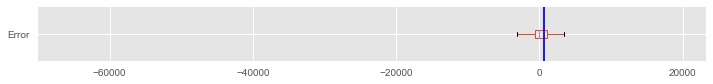

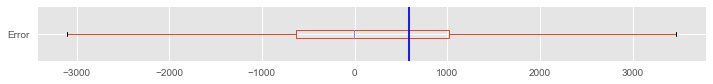

****************************************************************************************************



In [220]:
univariat_analysis_number(df_ohe_test, 'Error')

Wir haben wie erwartet extreme Ausreißer, allerdings verteilen sich die beiden mittleren Quartile schön um die ```0```. Der Median liegt tatsächlich nur ```5 $``` von der Null entfernt.

#### Betrachtung des MSE

In [223]:
print("MSE Baseline:\t\t{}".format(ols_m_fe_v1.mse_resid))
print("MSE Pipelinemodell:\t{}".format(mean_squared_error(df_ohe_test.Customer_Lifetime_Value, df_ohe_test.Predicted_CLV)))

MSE Baseline:		39607656.205343775
MSE Pipelinemodell:	50274820.36654651


Der MSE für das Gesamtkonstrukt hingegen sieht leider nicht wirklich gut aus - schlechter als das Baselinemodell.  
Fraglich ist, wie sich der MSE für die einzelnen Gruppen zeigt:

In [226]:
print("MSE Gruppe A:\t{}".format(mean_squared_error(df_ohe_test[df_ohe_test.Customer_Class=='A'].Customer_Lifetime_Value, df_ohe_test[df_ohe_test.Customer_Class=='A'].Predicted_CLV)))
print("MSE Gruppe B:\t{}".format(mean_squared_error(df_ohe_test[df_ohe_test.Customer_Class=='B'].Customer_Lifetime_Value, df_ohe_test[df_ohe_test.Customer_Class=='B'].Predicted_CLV)))
print("MSE Gruppe C:\t{}".format(mean_squared_error(df_ohe_test[df_ohe_test.Customer_Class=='C'].Customer_Lifetime_Value, df_ohe_test[df_ohe_test.Customer_Class=='C'].Predicted_CLV)))
print("MSE Gruppe D:\t{}".format(mean_squared_error(df_ohe_test[df_ohe_test.Customer_Class=='D'].Customer_Lifetime_Value, df_ohe_test[df_ohe_test.Customer_Class=='D'].Predicted_CLV)))

MSE Gruppe A:	129360256.10742874
MSE Gruppe B:	11413287.66306508
MSE Gruppe C:	32040676.605779722
MSE Gruppe D:	5914.040397404076


Der MSE für Gruppe ```D``` ist im Vergleich zu den bisher trainierten Modellen sehr viel besser, auch für die Gruppen ```B```und ```C``` hat der MSE sich im Vergleich zum Baseline-Modell verbessert.  
Speziell Gruppe ```A``` trifft das Los, dass der MSE schlechter ist als beim Baseline-Modell.

#### Betrachtung des R-squared

In [230]:
print("R^2 Baseline:\t\t{}".format(ols_m_fe_v1.rsquared_adj))
print("R^2 Pipelinemodell:\t{}".format(r2_score(df_ohe_test.Customer_Lifetime_Value, df_ohe_test.Predicted_CLV)))

R^2 Baseline:		0.1610359652301886
R^2 Pipelinemodell:	-0.02064843377597736


Der R-squared für das Pipelinemodell ist gelinde gesagt tragisch - das Pipelinemodell erklärt weniger der Varianz als der Mean für ```Customer_Lifetime_Value```.  
Wie verhält sich das für die einzelnen Gruppen?

In [232]:
print("R^2 für Gruppe A:\t ", r2_score(df_ohe_test[df_ohe_test.Customer_Class == 'A'].Customer_Lifetime_Value, df_ohe_test[df_ohe_test.Customer_Class == 'A'].Predicted_CLV))
print("R^2 für Gruppe B:\t ", r2_score(df_ohe_test[df_ohe_test.Customer_Class == 'B'].Customer_Lifetime_Value, df_ohe_test[df_ohe_test.Customer_Class == 'B'].Predicted_CLV))
print("R^2 für Gruppe C:\t ", r2_score(df_ohe_test[df_ohe_test.Customer_Class == 'C'].Customer_Lifetime_Value, df_ohe_test[df_ohe_test.Customer_Class == 'C'].Predicted_CLV))
print("R^2 für Gruppe D:\t ", r2_score(df_ohe_test[df_ohe_test.Customer_Class == 'D'].Customer_Lifetime_Value, df_ohe_test[df_ohe_test.Customer_Class == 'D'].Predicted_CLV))

R^2 für Gruppe A:	  -0.40364903577279243
R^2 für Gruppe B:	  0.050261642564739084
R^2 für Gruppe C:	  -0.32679569310339573
R^2 für Gruppe D:	  0.9798804018333098


Auch für die Gruppen ist das Bild nicht viel besser - mit Ausnahme der Gruppe ```D```: hier liegt der R-squared 
bei ```0.98```, das bedeutet, es werden ```98%``` der Streuung erklärt.  
Dieses Ergebnis hatten wir so nicht erwartet, wenn zwei Modellen in Reihe geschaltet werden.

## Communication

__Zielerfüllung:__  
Wir hatten uns zwei Ziele gesteckt: 
+ Regression für den ```Customer_Lifetime_Value```:
    + Wir konnten unser Ziel für de untersten 25% der Kunden erfüllen - mit einem R-squared von ```0.98``` 